# Extraction of signal over background from spectral data, in different data taking conditions, using a Markov Chain Monte Carlo with a Gibbs sampler

### Importing libraries

In [4]:
#load the working space
load(file="my-session.gz")

In [5]:
options(repr.plot.width=5, repr.plot.height=5)
library("PerformanceAnalytics")
library(rjags)
library(coda)
library(ggplot2)
library(gplots)
library(ggthemes)

## Importing spectrum from the dat file.

In [6]:
file <- "./B19036_AmCsCo_20180316.dat"
adc.df <- read.csv(file,skip=1,stringsAsFactors = FALSE) # skip first 2 lines which are text
nrow(adc.df) # Number of rows
ncol(adc.df) # Number of columns
#head(adc.df)

[1] 8192

[1] 1

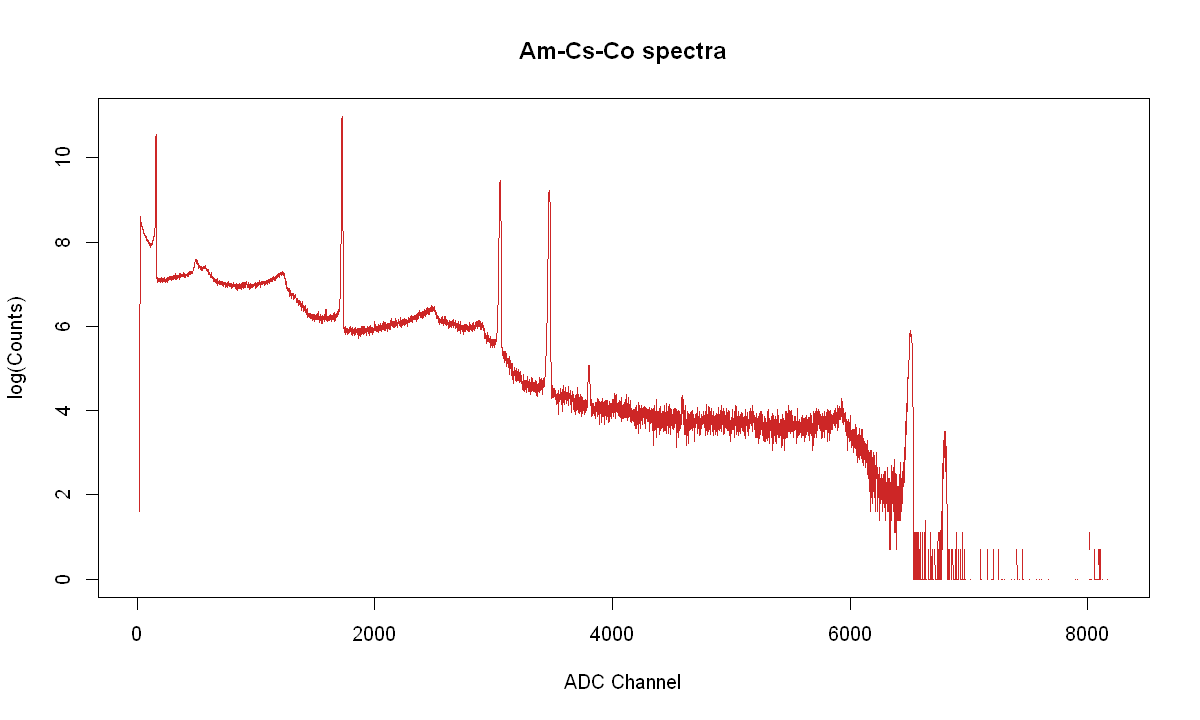

In [7]:
options(repr.plot.width=10, repr.plot.height=6)

# ADC(channels) vs log(counts)
data <- NULL
x_min <- 0
x_max <- 8191
data$x <- seq(x_min,x_max) 

data$y <-  adc.df[[1]]  # log is used to see the background noise better
# wherever 0's are there, after applying log, it becomes -Inf

plot(data$x, log(data$y),col='firebrick3',type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="Am-Cs-Co spectra")

The information provided to us is as follows, the first 4 peaks correspond to the following nucleii:



| Nuclei | Photon Energy (keV) | |
|------|------| ---- |
|  241Am | 59.54 |  |
|  137Cs | 661.66 |   |
|  60Co | 1173.24 | 1332.51 |





## Analysis of first peak Am-241

We begin our study by analysing the peak correspoding to Am-241. 

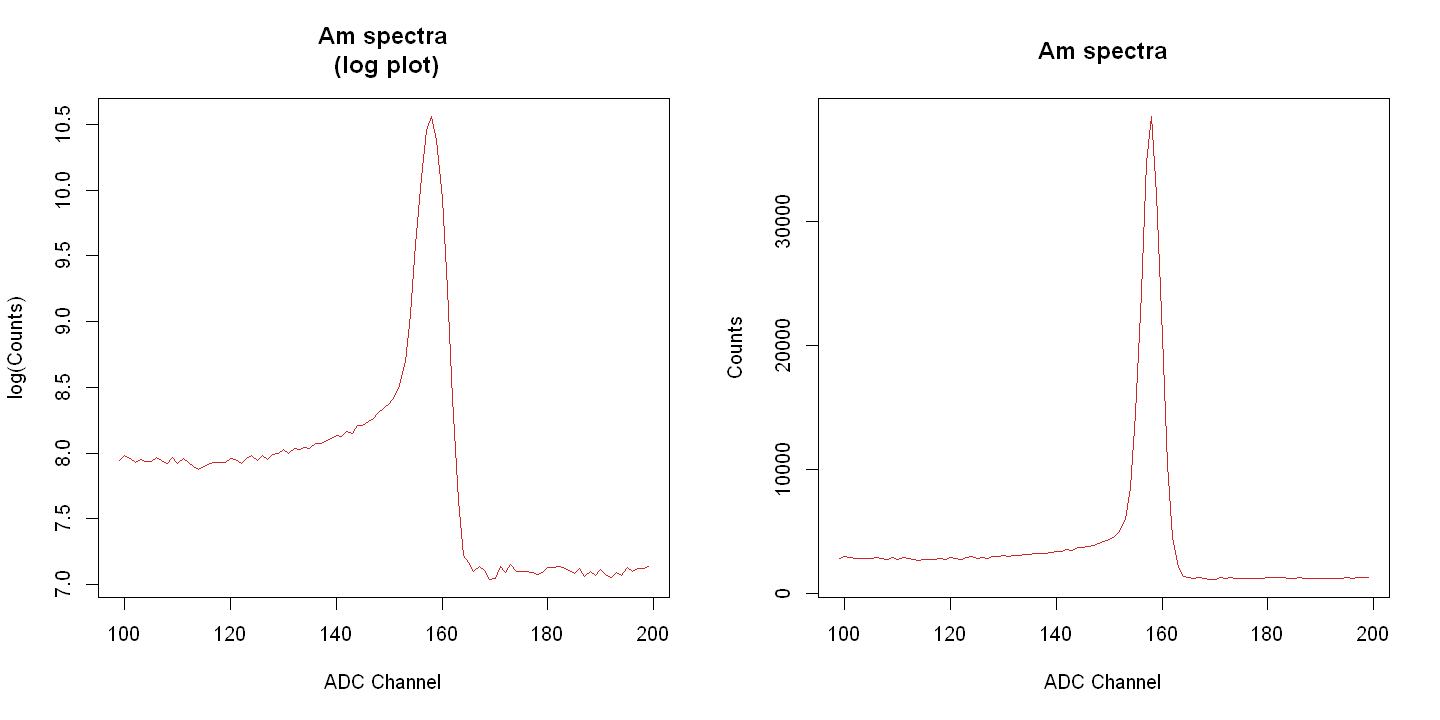

In [8]:
# Plotting only the spectra of Am-241
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
Am.data <- NULL
Am.data$x <- data$x[100:200] # 100 data points from 100 to 200 gives window for the first peak for Am241
Am.data$y <- data$y[100:200]

# log plot
plot(Am.data$x, log(Am.data$y), col='firebrick3', type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="Am spectra\n (log plot)")
# original plot
plot(Am.data$x, Am.data$y, col='firebrick3', type='l',xlab="ADC Channel",ylab="Counts",
     main="Am spectra")

In order to find the distribution of the peak considering the background we are going to apply a MCMC method using gibbs sampler. In particular JAGS. 

The model we used is presented as follows:

model{

    for (i in 1:length(x)){
	S[i] <- (A*exp((-(x[i]-x0)^2)/(2*w^2))+B)
	y[i] ~ dpois(S[i]) # likelihood of the data
    } 
    
    # uniform prior w, A, B, x0
    # the prior values for the params below were considered just by observing the graphs #so that chain doesn't waste time in checking out parameter space other than the given #limits as below	
    A ~ dunif(0,60000)
    B ~ dunif(0,5000)
    
    w ~ dunif(0,35)
    
    x0 ~ dunif(140,180)
    #delta_t ~ dunif(0,20)   
}    


The parameters follows a uniform prior distribution since we lack of information about them.

In order to apply JAGS, we needed to initializate the parameters, those were considered just by roughly observing the corresponding graph of the peak.

We run the algorithm for 2e5 interations with a thin of 100.

In [9]:
# Initial parameter values
init <- NULL
init$A <- 30000
init$B <- 5000
init$w <- 8
init$x0 <- 150

In [10]:
#running jags
# set the seed 
set.seed(12345)

# Create the model and pass the parameters
jm <- jags.model("./Am241.bug", Am.data , init)

# Update the Markov chain (Burn -in)
update (jm , 4000)

Am.chain <- coda.samples(jm , variable.names=c("A","B","x0","w"), n.iter = 2e5, thin = 100)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 4
   Total graph size: 922

Initializing model



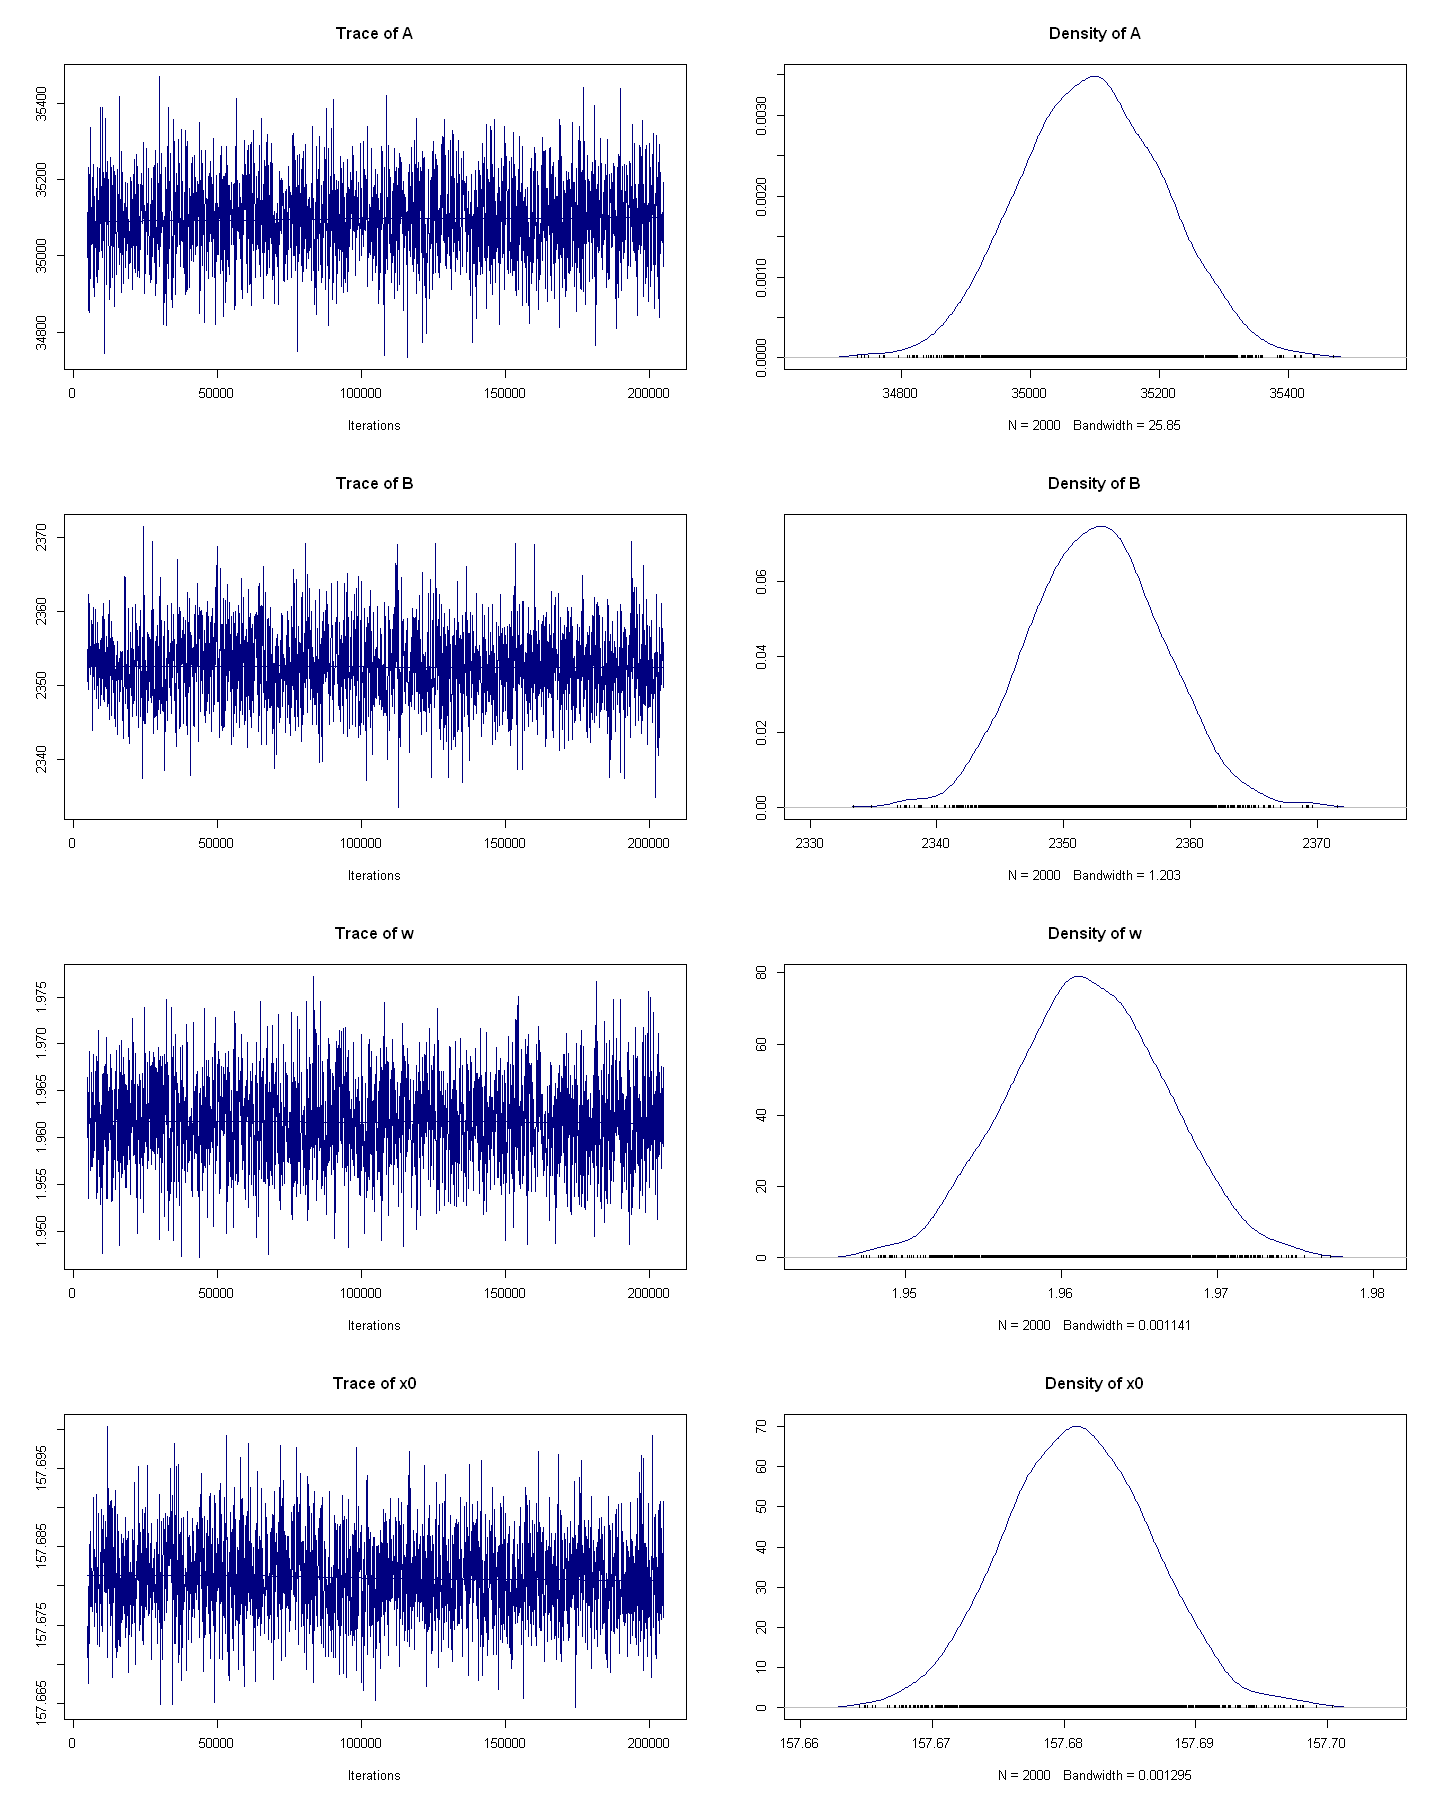

In [11]:
# plotting the chain, posterior distributions of the parameters
options(repr.plot.width=12, repr.plot.height=15)
plot(Am.chain, col='navy')

As it can be seen, the algorithm converges well since from the left hand side of above graph:
    1. the sample is moving through the space quite satisfactorily. There arent too many consecutive steps in one direction. 
    2. extreme values are selected, from time to time, but the chain tends to jump back to the central region(higher probability) very quickly.

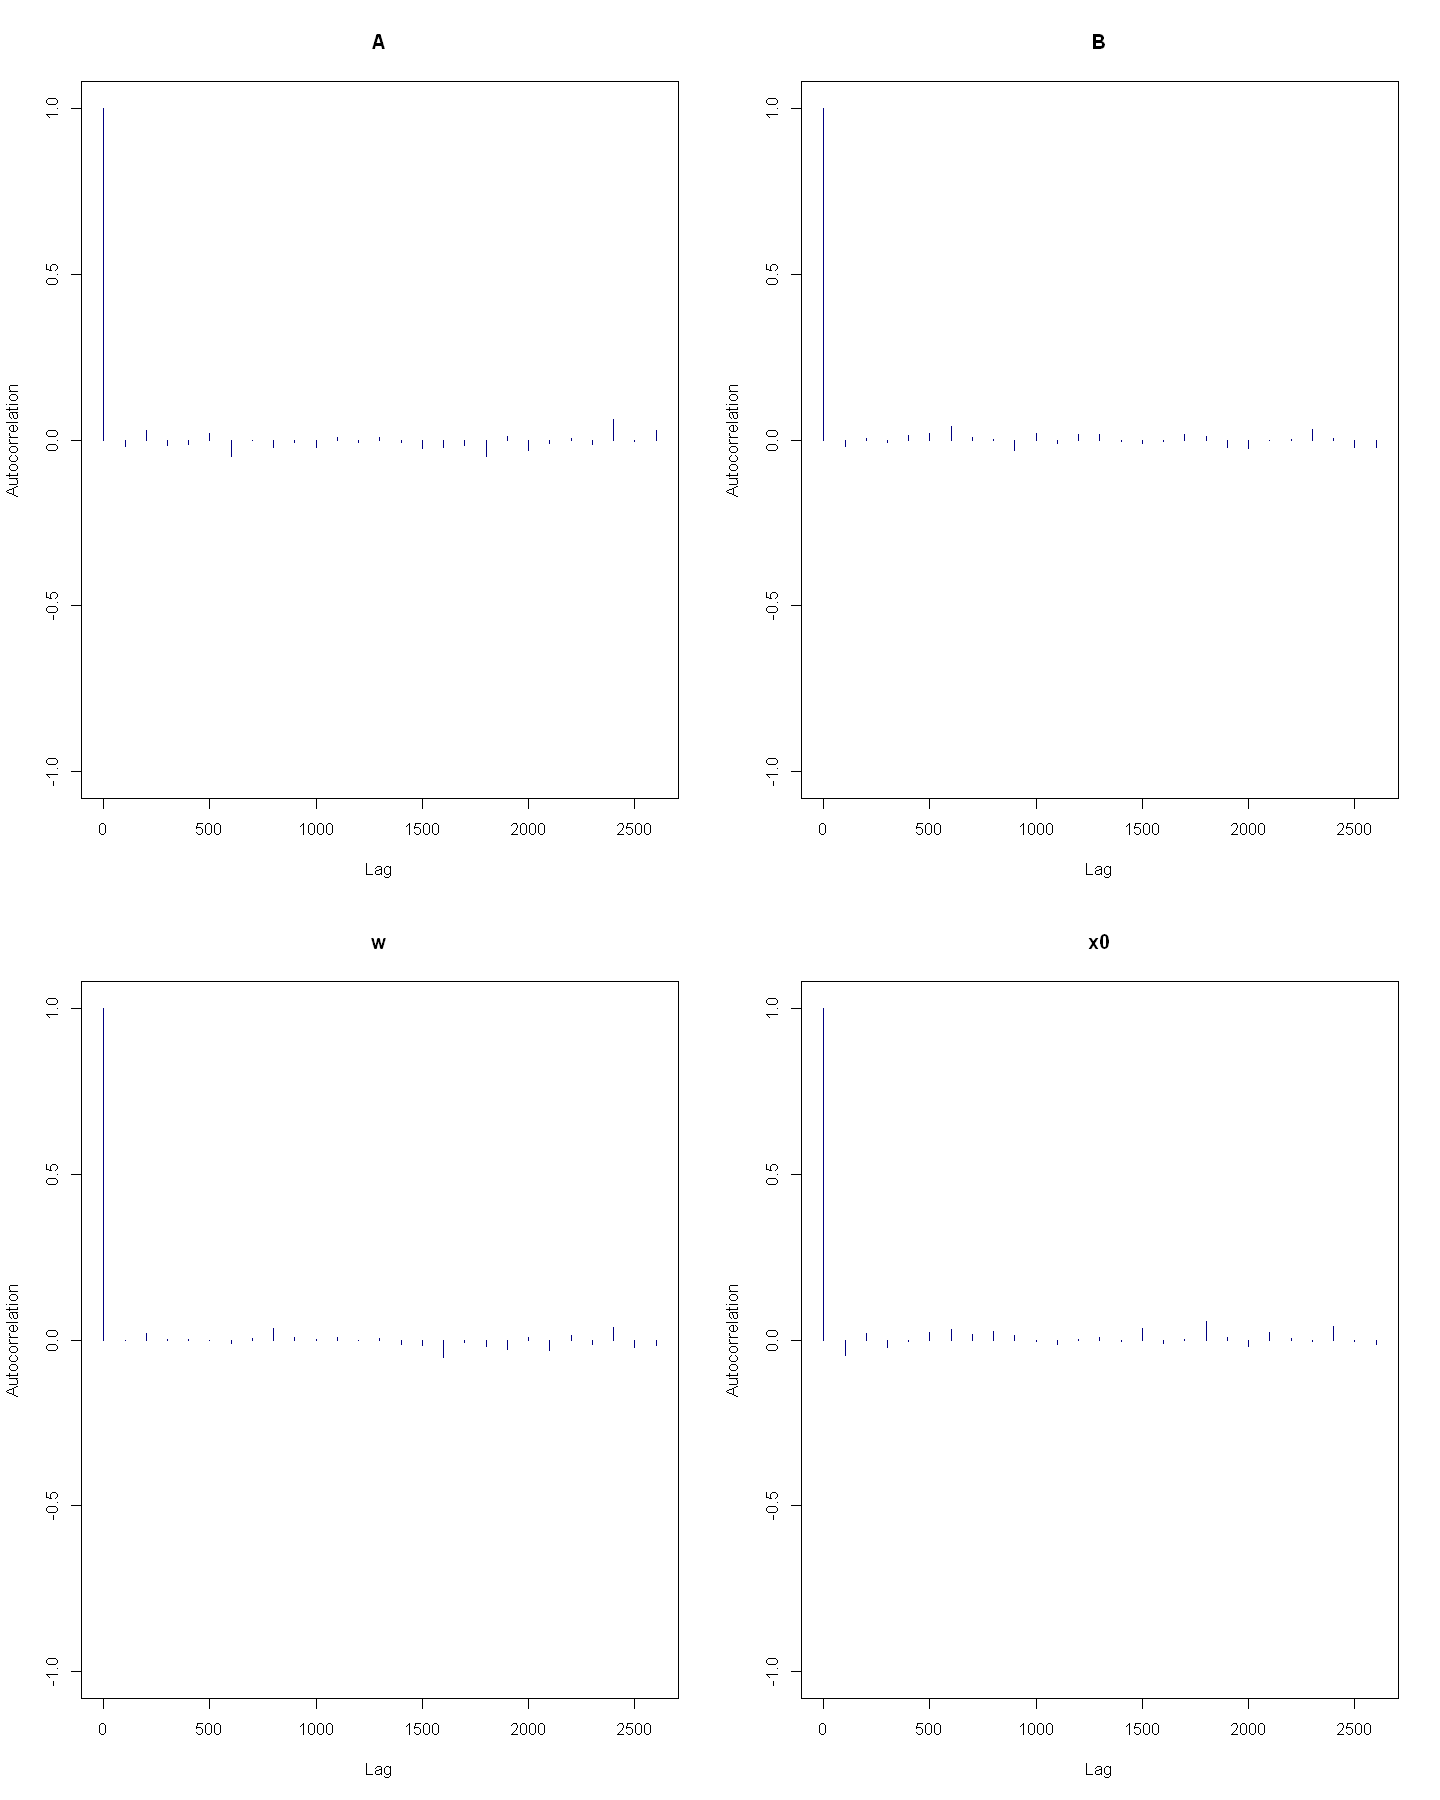

In [12]:
autocorr.plot(Am.chain, col='navy')

The autocorrelation drops immediatly with increasing "lag".

In [13]:
#here we present some results of our chain
summary(Am.chain)


Iterations = 5100:205000
Thinning interval = 100 
Number of chains = 1 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean        SD  Naive SE Time-series SE
A  35095.962 1.115e+02 2.4933283      2.4933283
B   2352.588 5.241e+00 0.1171830      0.1171830
w      1.962 4.939e-03 0.0001104      0.0001104
x0   157.681 5.589e-03 0.0001250      0.0001193

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  34883.945 35020.294 35096.146 35172.417 35312.215
B   2342.731  2349.049  2352.578  2356.001  2362.696
w      1.952     1.958     1.962     1.965     1.971
x0   157.671   157.677   157.681   157.685   157.692


In [14]:
# Format our chain
chain.df <- as.data.frame(as.mcmc(Am.chain))

# A Quantitative way for correlation of parameters
cat(sprintf ("\n Correlation matrix : \n"))
print(cor(chain.df))


 Correlation matrix : 
             A           B          w          x0
A   1.00000000  0.02685982 -0.5981186  0.03914406
B   0.02685982  1.00000000 -0.1893537  0.04219536
w  -0.59811862 -0.18935368  1.0000000 -0.11143198
x0  0.03914406  0.04219536 -0.1114320  1.00000000


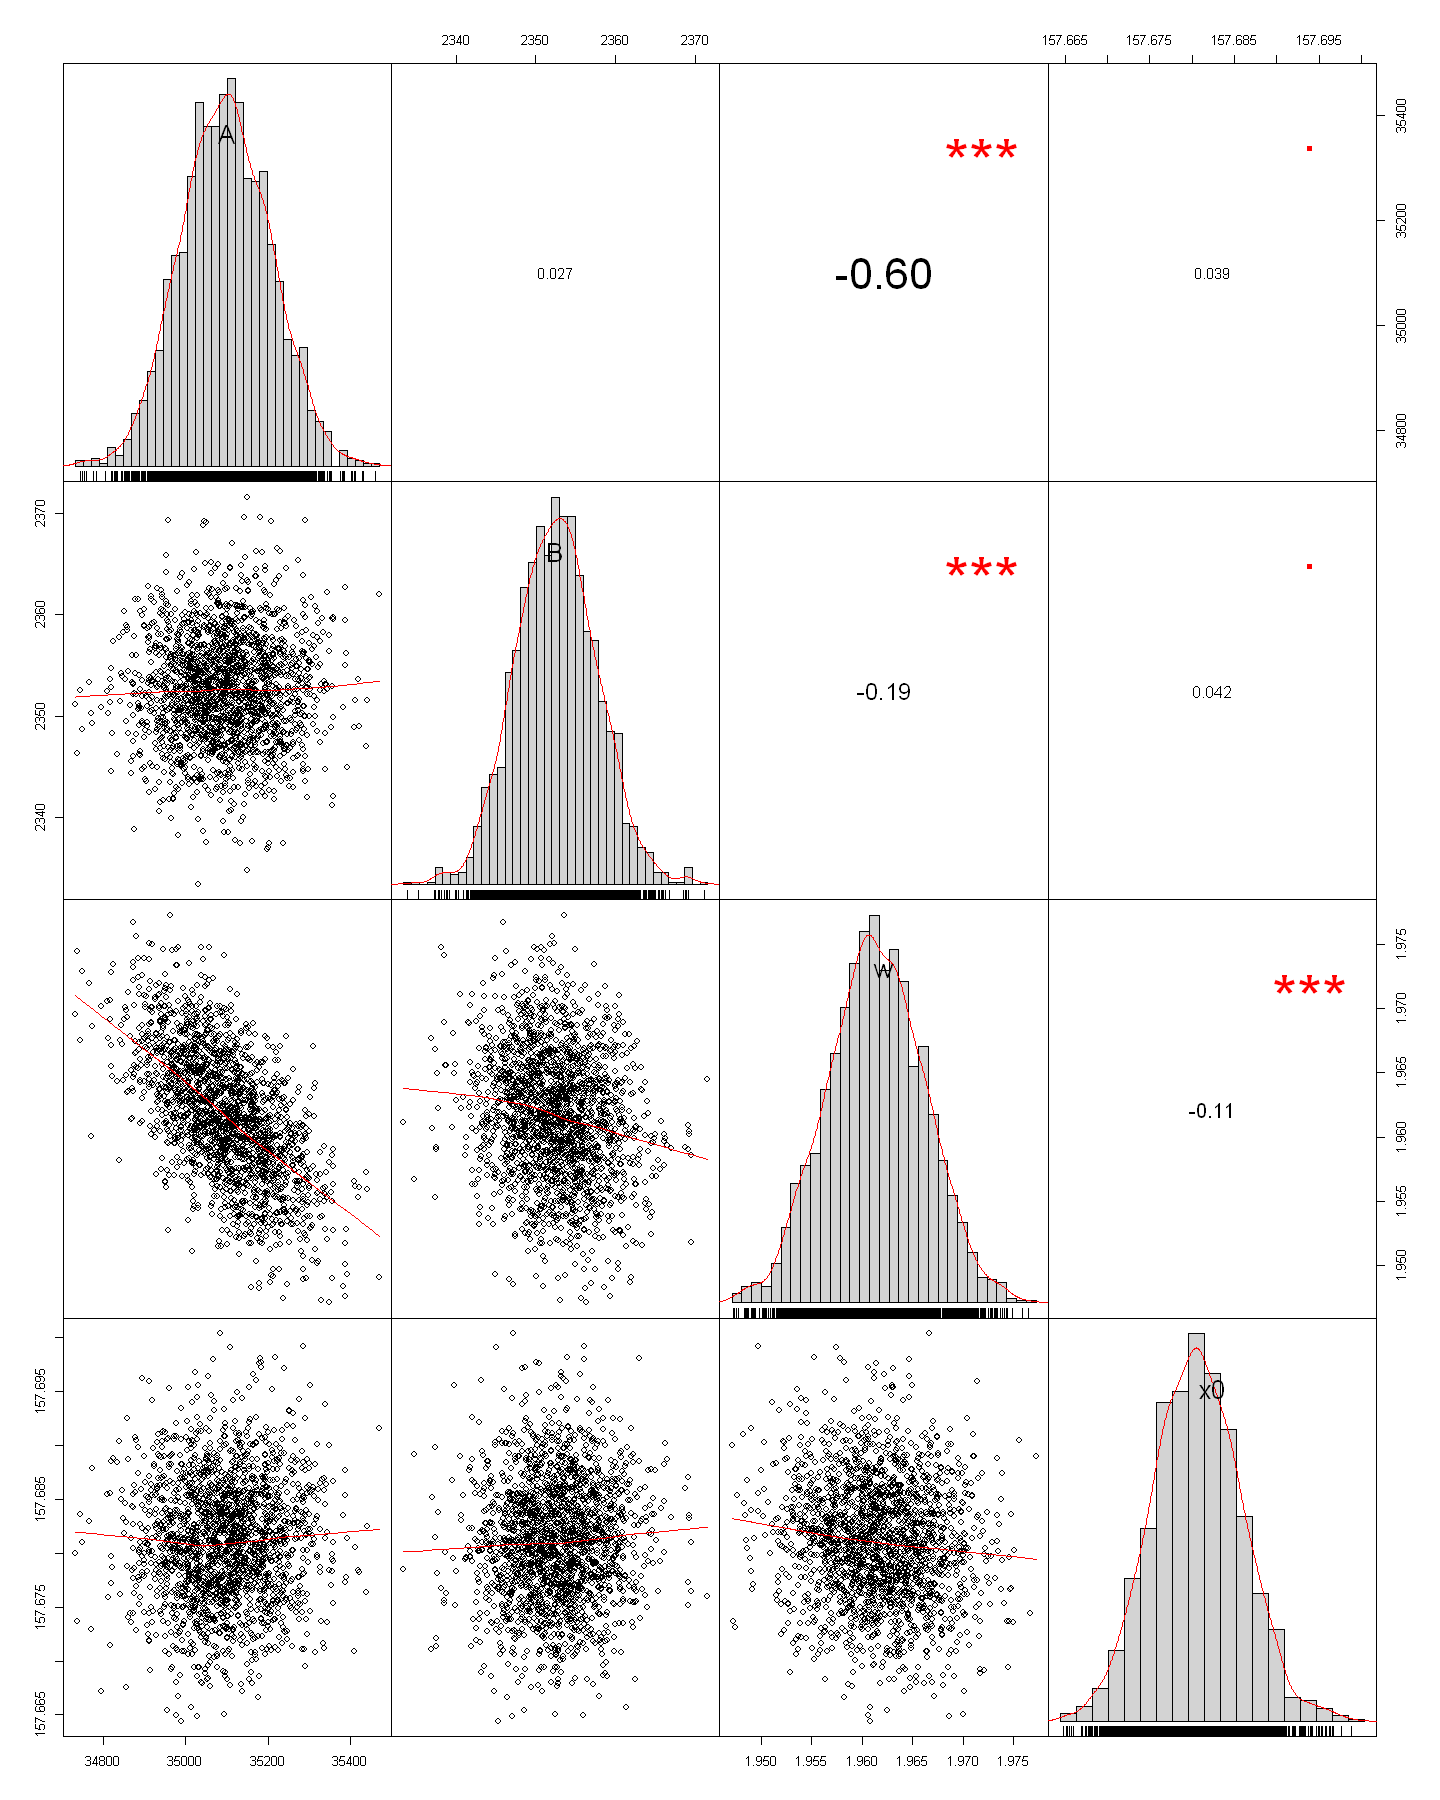

In [15]:
# Scatter plot of all the parameters. 
options(repr.plot.width=12, repr.plot.height=15)

chart.Correlation(chain.df, histogram = T, pch= 19)

The above graph shows the correlation of all the parameters. It is visual way to understand the correlation among them. 

1. We see that in figure(1,3), we see a negative correlation between Amplitude and the width of the peak. This is as it should be since with the increase in the width of peak, the signal amplitude goes down. We also observe that amplitude and B(background) and A & x0 are uncorrelated as the points are scattered randomly.

2. B & w, B & x0 are also uncorrelated

3. w & x0 are uncorrelated.


In [16]:
#function to plot histogram
#argument --> chain
histogram.plot <- function(chain){
    chain.df <- as.data.frame( as.mcmc(chain) )
    colors <- c('darkolivegreen2','coral2','darkseagreen4','violet')
    params <- c("A","B","w","x0")
    sch <- summary(chain)
    
    options(repr.plot.width=12, repr.plot.height=13)
    par(mfrow=c(2,2), mgp=c(2.0,0.8,0), mar=c(3.5,3.5,1,1), oma=0.1*c(1,1,1,1))
    
    for (i in seq(1,4)){
    hist(chain.df[[i]], nc=100, prob=TRUE, col=colors[i],
    xlab=params[i], ylab=paste('f(',params[i],')'), main=paste('Inference on',params[i]),cex.main=1.3,cex.lab=1.3)
    legend('topleft',legend=paste(round(sch$statistics[i,1],2),'+/-',round(sch$statistics[i,2],2)),
           bty='n',cex=1.4)
        
    }
}

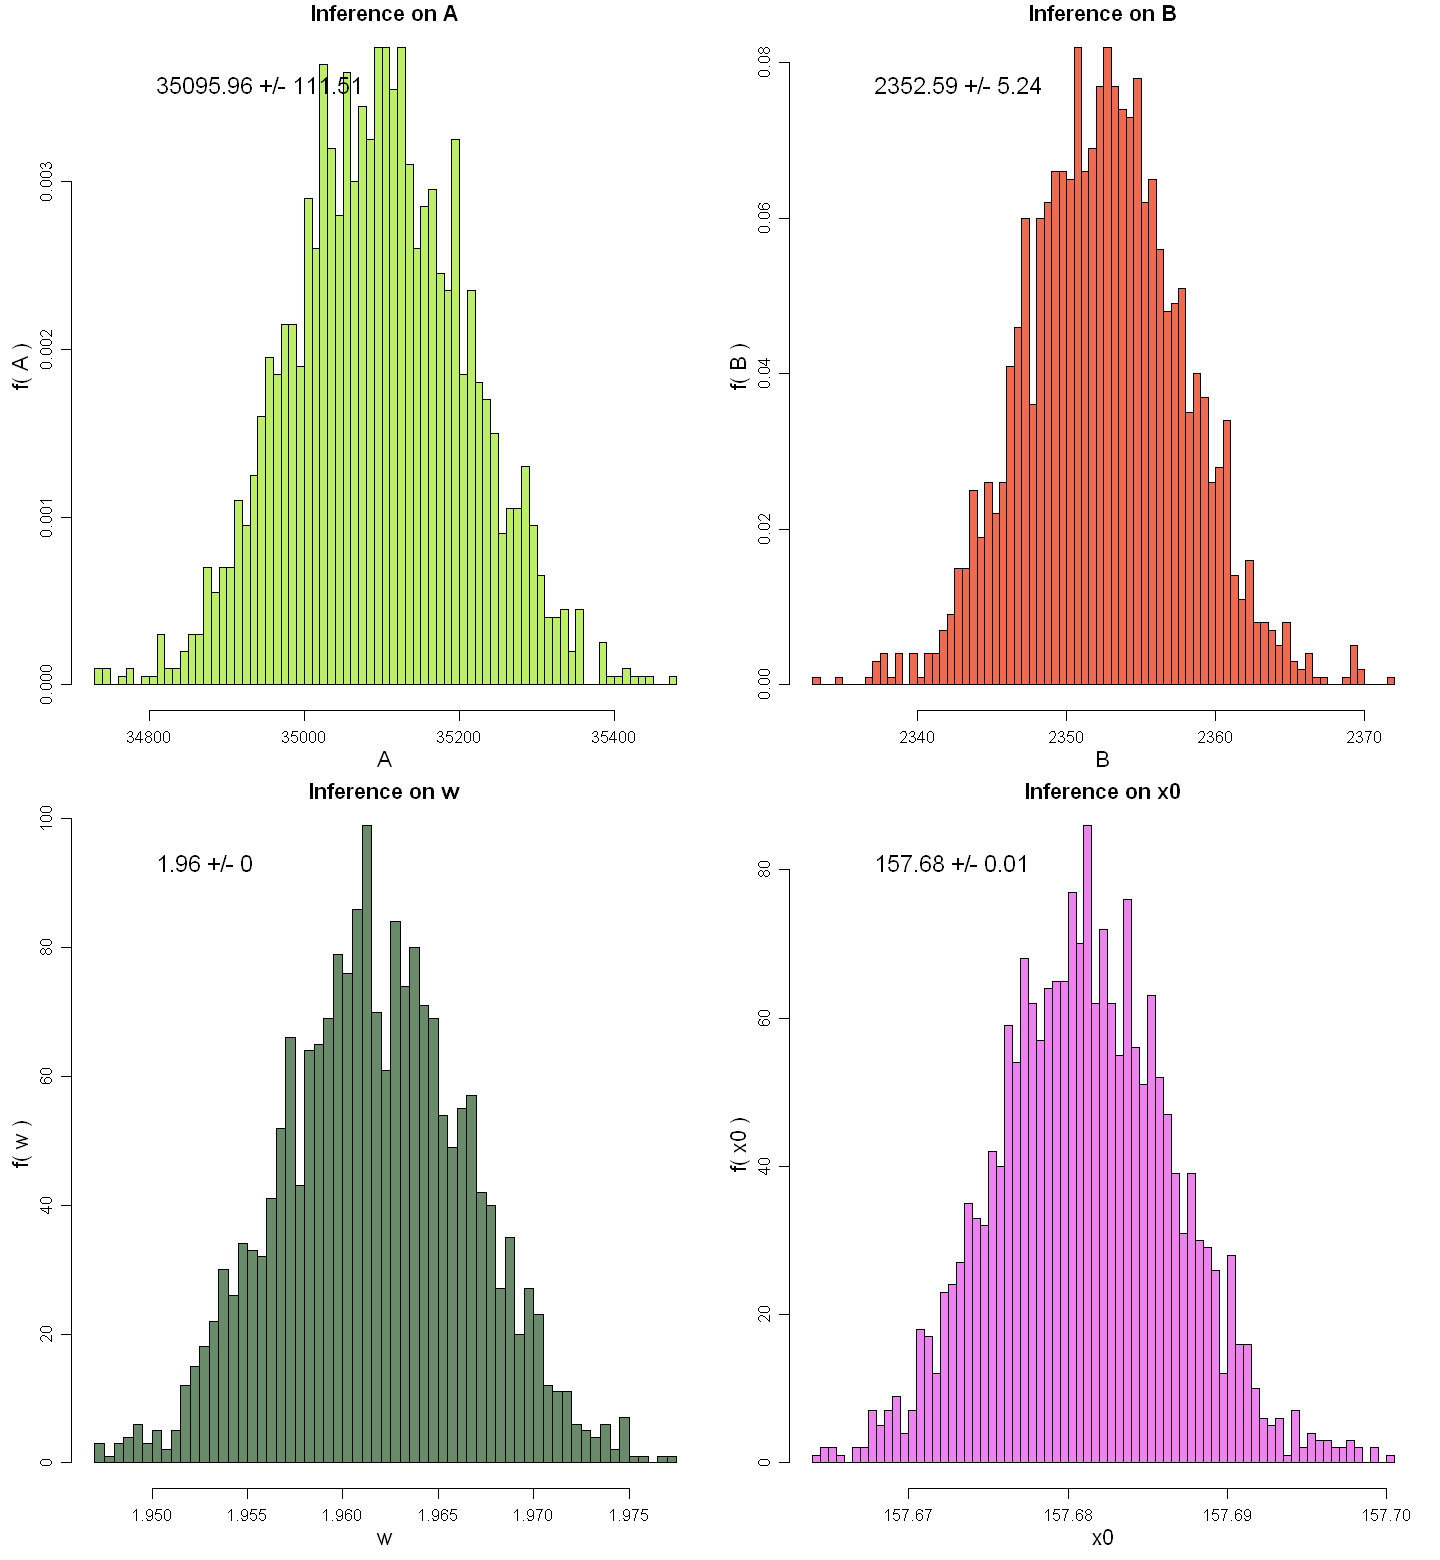

In [17]:
histogram.plot(Am.chain)

In [18]:
# function to extract mean, sd and 95% CI
#argument --> chain
Estimates <- function(chain){
    sch <- summary(chain)
    i=1
    cat("Estimates for the posterior distributions of parameters are:\n param: mean +/- sd")
    for (params in c("A","B","w","x0")){
    cat("\n",params,":",sch$statistics[i,1],'+/-',sch$statistics[i,2])
    i=i+1
         }
    i=1
    cat("\n\n95% CI for each posterior dist. of parameters:\n param: lower_limit - upper_limit")
    for (params in c("A","B","w","x0")){
    cat("\n",params,":",sch$quantiles[i,1],'-',sch$quantiles[i,5])
    i=i+1
         }
    estimates <- NULL
    estimates$A <- sch$statistics[1,1]
    estimates$B <- sch$statistics[2,1]
    estimates$w <- sch$statistics[3,1]
    estimates$x0 <- sch$statistics[4,1]
   
    return(estimates)
    
}

In [19]:
# All the estimates of params for Am-241 like
# A --> Signal Amplitude
# B ---> Background counts
# w ----> width of the peak
# x0 ----> 
Am.estimates <- Estimates(Am.chain)

Estimates for the posterior distributions of parameters are:
 param: mean +/- sd
 A : 35095.96 +/- 111.505
 B : 2352.588 +/- 5.240584
 w : 1.961669 +/- 0.004938908
 x0 : 157.6811 +/- 0.005589032

95% CI for each posterior dist. of parameters:
 param: lower_limit - upper_limit
 A : 34883.94 - 35312.22
 B : 2342.731 - 2362.696
 w : 1.952271 - 1.971248
 x0 : 157.6706 - 157.6918

In [20]:
Am.estimates

$A
[1] 35095.96

$B
[1] 2352.588

$w
[1] 1.961669

$x0
[1] 157.6811

## Convergence check

Even though the behaviour shown of the trace of the chain is an indicator of a efficient sampler of the MCMC,  just in case we are going to run the same chain again to check if they converge to the same density plots.

One of the simplest ways to check whether the chain has reached a steady state is
to rerun the sampling several times, with different starting points -> all chains
should converge to the same region of parameter space

In [21]:
convergence.check <- function(init){
   # set the seed 
    set.seed(12345)

    # Create the model and pass the parameters
    jm <- jags.model("./Am241.bug", Am.data , init)

    # Update the Markov chain (Burn -in)
    update (jm , 4000)

    chain <- coda.samples(jm , variable.names=c("A","B","x0","w"), n.iter = 2e5, thin = 100)
    results <- Estimates(chain)
    
    return(results)
}

In [22]:
init2 <- NULL
init2$A <- 50000
init2$B <- 3500
init2$w <- 20
init2$x0 <- 180
estimates.2 <- convergence.check(init2)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 4
   Total graph size: 922

Initializing model

Estimates for the posterior distributions of parameters are:
 param: mean +/- sd
 A : 35098.12 +/- 117.7543
 B : 2352.317 +/- 5.084994
 w : 1.961542 +/- 0.005032517
 x0 : 157.6812 +/- 0.005664815

95% CI for each posterior dist. of parameters:
 param: lower_limit - upper_limit
 A : 34868.25 - 35329.53
 B : 2342.564 - 2362.478
 w : 1.95205 - 1.971144
 x0 : 157.6699 - 157.6923

In [23]:
# Initial parameter values
init3 <- NULL
init3$A <- 25000
init3$B <- 2000
init3$w <- 15
init3$x0 <- 140
convergence.check(init3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 4
   Total graph size: 922

Initializing model

Estimates for the posterior distributions of parameters are:
 param: mean +/- sd
 A : 35093.22 +/- 118.8054
 B : 2352.515 +/- 5.136485
 w : 1.961635 +/- 0.004956192
 x0 : 157.6812 +/- 0.005578729

95% CI for each posterior dist. of parameters:
 param: lower_limit - upper_limit
 A : 34851.85 - 35325.1
 B : 2342.46 - 2362.441
 w : 1.952086 - 1.971388
 x0 : 157.6703 - 157.6917

$A
[1] 35093.22

$B
[1] 2352.515

$w
[1] 1.961635

$x0
[1] 157.6812

In [24]:
# Initial parameter values
init4 <- NULL
init4$A <- 20000
init4$B <- 4000
init4$w <- 5
init4$x0 <- 170
convergence.check(init4)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 4
   Total graph size: 922

Initializing model

Estimates for the posterior distributions of parameters are:
 param: mean +/- sd
 A : 35094.96 +/- 112.9274
 B : 2352.385 +/- 5.290706
 w : 1.961527 +/- 0.0048547
 x0 : 157.6811 +/- 0.005638712

95% CI for each posterior dist. of parameters:
 param: lower_limit - upper_limit
 A : 34871.36 - 35326.82
 B : 2341.98 - 2362.331
 w : 1.951614 - 1.971117
 x0 : 157.6699 - 157.6919

$A
[1] 35094.96

$B
[1] 2352.385

$w
[1] 1.961527

$x0
[1] 157.6811

In [25]:
# Initial parameter values
init5 <- NULL
init5$A <- 25000
init5$B <- 2000
init5$w <- 15
init5$x0 <- 120
convergence.check(init5)
# we get error here since x0<- 120 is not a correct initilization when we see the peak. 
# x0 should always be between 140 to 170 atmost.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 4
   Total graph size: 922

Initializing model
Deleting model



ERROR: Error in jags.model("./Am241.bug", Am.data, init): Error in node x0
Node inconsistent with parents




We are falling again into the same values that we've got so indeed this chain converges satisfactory


## Effect of burn-in on Auto-correlation

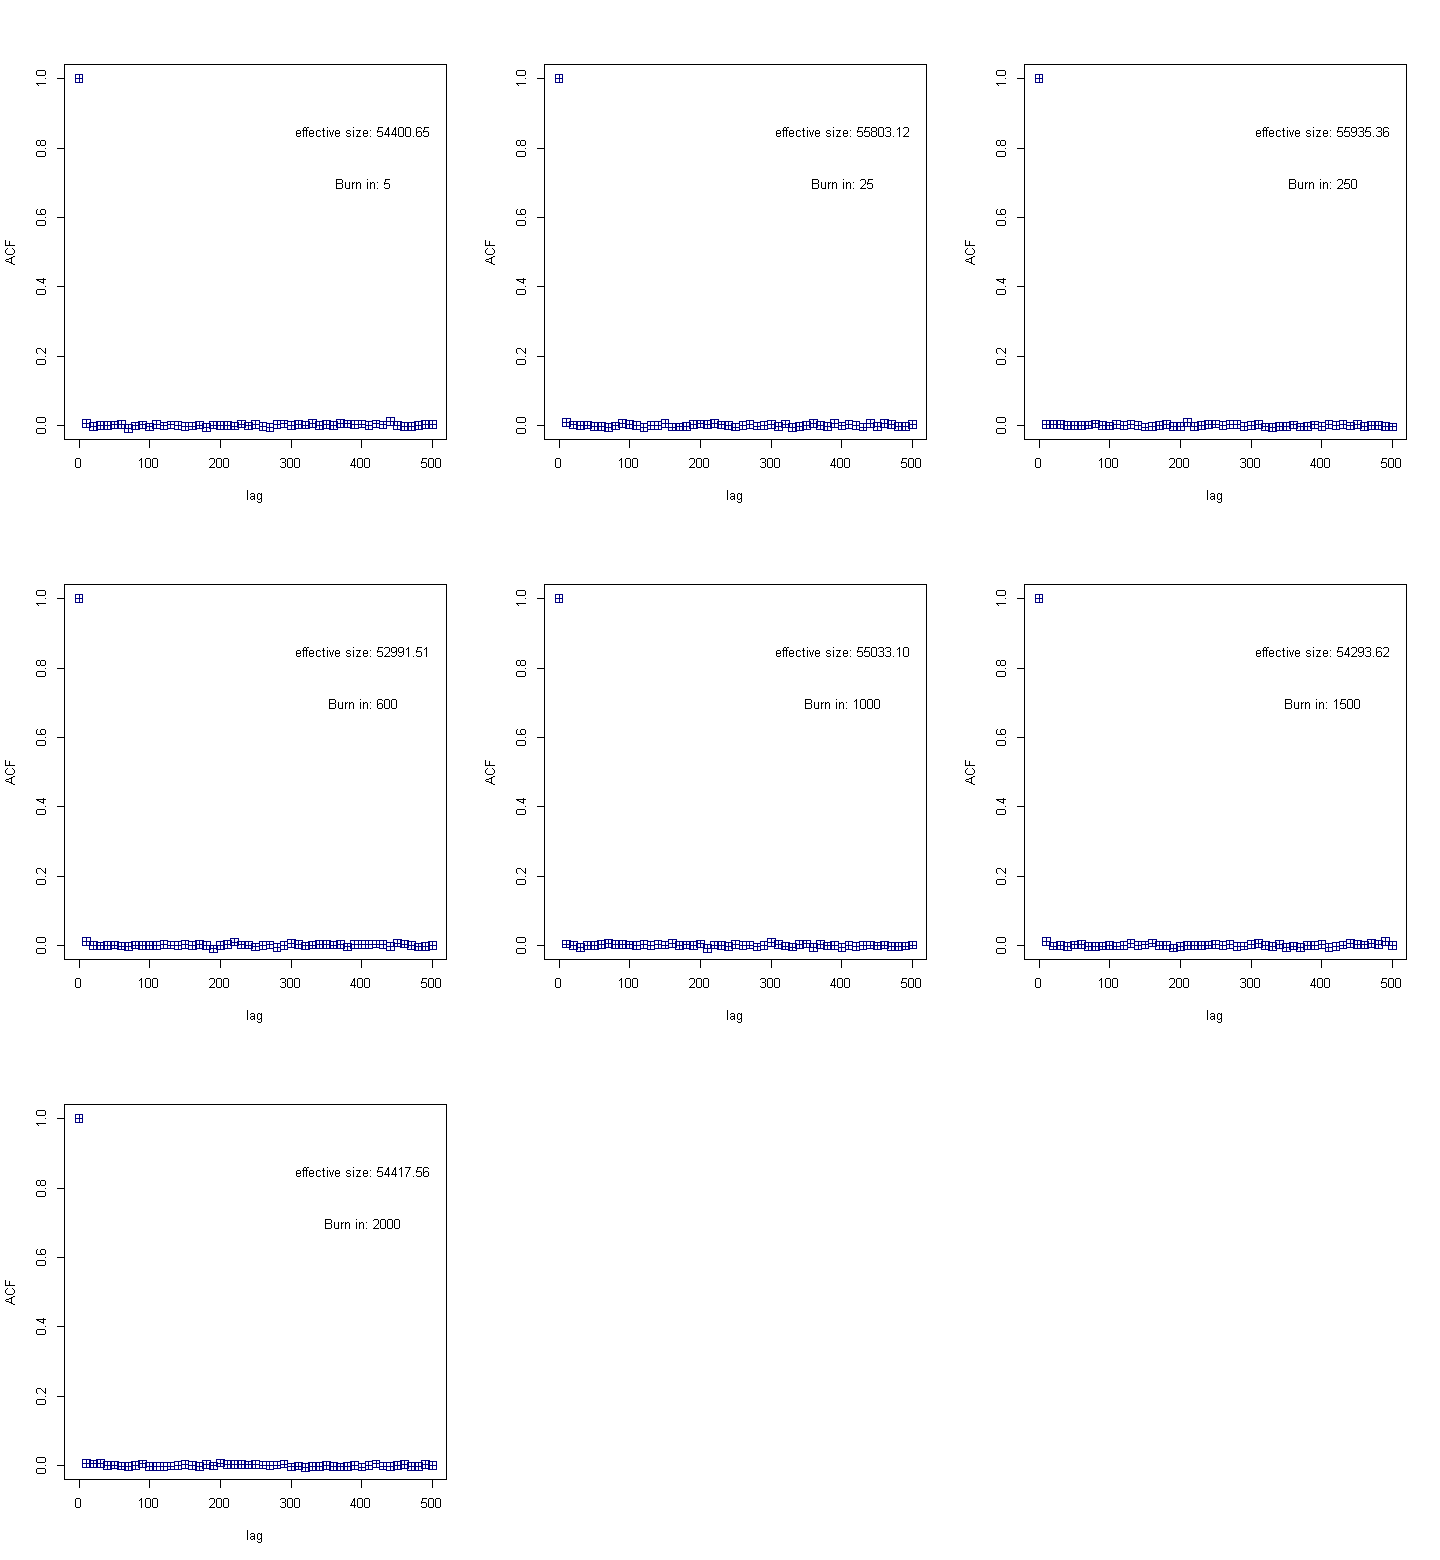

In [26]:
options(repr.plot.width=12, repr.plot.height=13)
par(mfrow=c(3,3))
burnin.vals <- c(5,25,250, 600, 1000,1500,2000)
A.mean <- data.frame()
B.mean <- data.frame()
x0.mean <- data.frame()
w.mean <- data.frame()
for (burn in burnin.vals){
  update(jm , burn)
  chain <- coda.samples(jm , variable.names=c("A","B","x0","w"), n.iter = 2e5, thin = 1)

  # chain.df is dataframe of A, B, w and x0 with all 2e5 iterations or rows because we use thin=1.
  # the strategy is to see how auto-correlation varies with both 
  # burn-in and thin-in.  
  chain.df <- as.data.frame(as.mcmc(chain))
  summ <- summary(chain) 
  A.mean<-rbind(A.mean,summ$statistics[1,1:2]) 
  B.mean<-rbind(B.mean,summ$statistics[2,1:2])
  x0.mean<-rbind(x0.mean,summ$statistics[3,1:2])
  w.mean<-rbind(w.mean,summ$statistics[4,1:2])
    
  my.lags = seq(0,500,10) # here we have a constant lags of 10
  # Here we need use as.mcmc(chain.df$b0) because we need to give it as an input to autocorr
  y1 <- autocorr(as.mcmc(chain.df$A), lags=my.lags)
  plot(my.lags , y1, ylim=c(0,1),pch=12, col='navy',
        xlab='lag', ylab='ACF', cex=1.3)
  text(400,0.85, sprintf (" effective size: %.2f", effectiveSize(as.mcmc(chain.df$A))))
  text(400,0.7, sprintf (" Burn in: %d", burn))
}

In [27]:
colnames(A.mean)  <- c('A mean', 'sd A')
colnames(B.mean)  <- c('B mean', 'sd B')
colnames(x0.mean)  <- c('x0 mean', 'sd x0')
colnames(w.mean)  <- c('w mean', 'sd w')

df <- data.frame(A.mean, B.mean, x0.mean, w.mean, burnin.vals)

In [28]:
burnin.plot <- function(data, i){
    #data must content x and values
    # i represent the data that you want to plot 
    # i <- 1 parameter A
    # i <- 2 parameter B
    # i <- 3 parameter x0
    # i <- 4 parameter w
    
    colors <- c('darkolivegreen2','coral2','darkseagreen4','violet')
    params <- c("A","B","x0","w")
    sch <- summary(chain)
    j <- i
    if (i == 2){i <- 3}
    else if(i == 3){i <- 5}
    else if(i == 4){i <- 7}
    
    options(repr.plot.width=8, repr.plot.height=2)
    g <- ggplot(data, aes(x= df[,9], y=df[,i])) + geom_line(linetype = "dashed", col = colors[j]) +geom_point(col=colors[j])
    g <- g +  theme_minimal() + labs(x = 'Burn-in values', y = params[j])
    g <-  g + geom_errorbar(aes(ymin=df[,i]-(df[,i+1])/sqrt(length(df[,9])), ymax=df[,i]+(df[,i+1])/sqrt(length(df[,9]))), col = colors[j], width=.2, position=position_dodge(0.05))
    g 
    
    
}

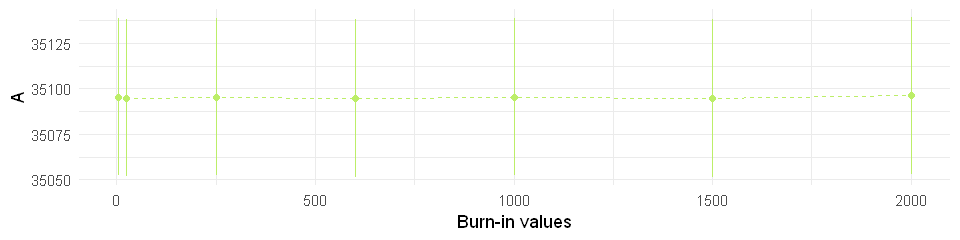

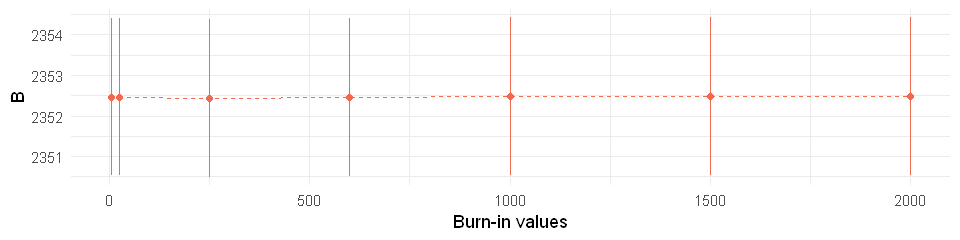

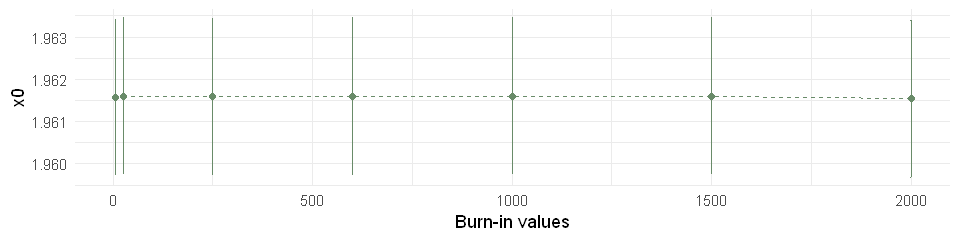

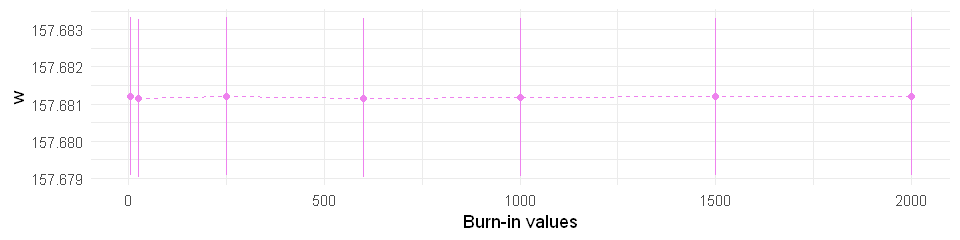

In [29]:
burnin.plot(df, 1)
burnin.plot(df, 2)
burnin.plot(df, 3)
burnin.plot(df, 4)

The burn in values doesnt affect on the results we obtained. 

## Effect of thinning on Auto-correlation

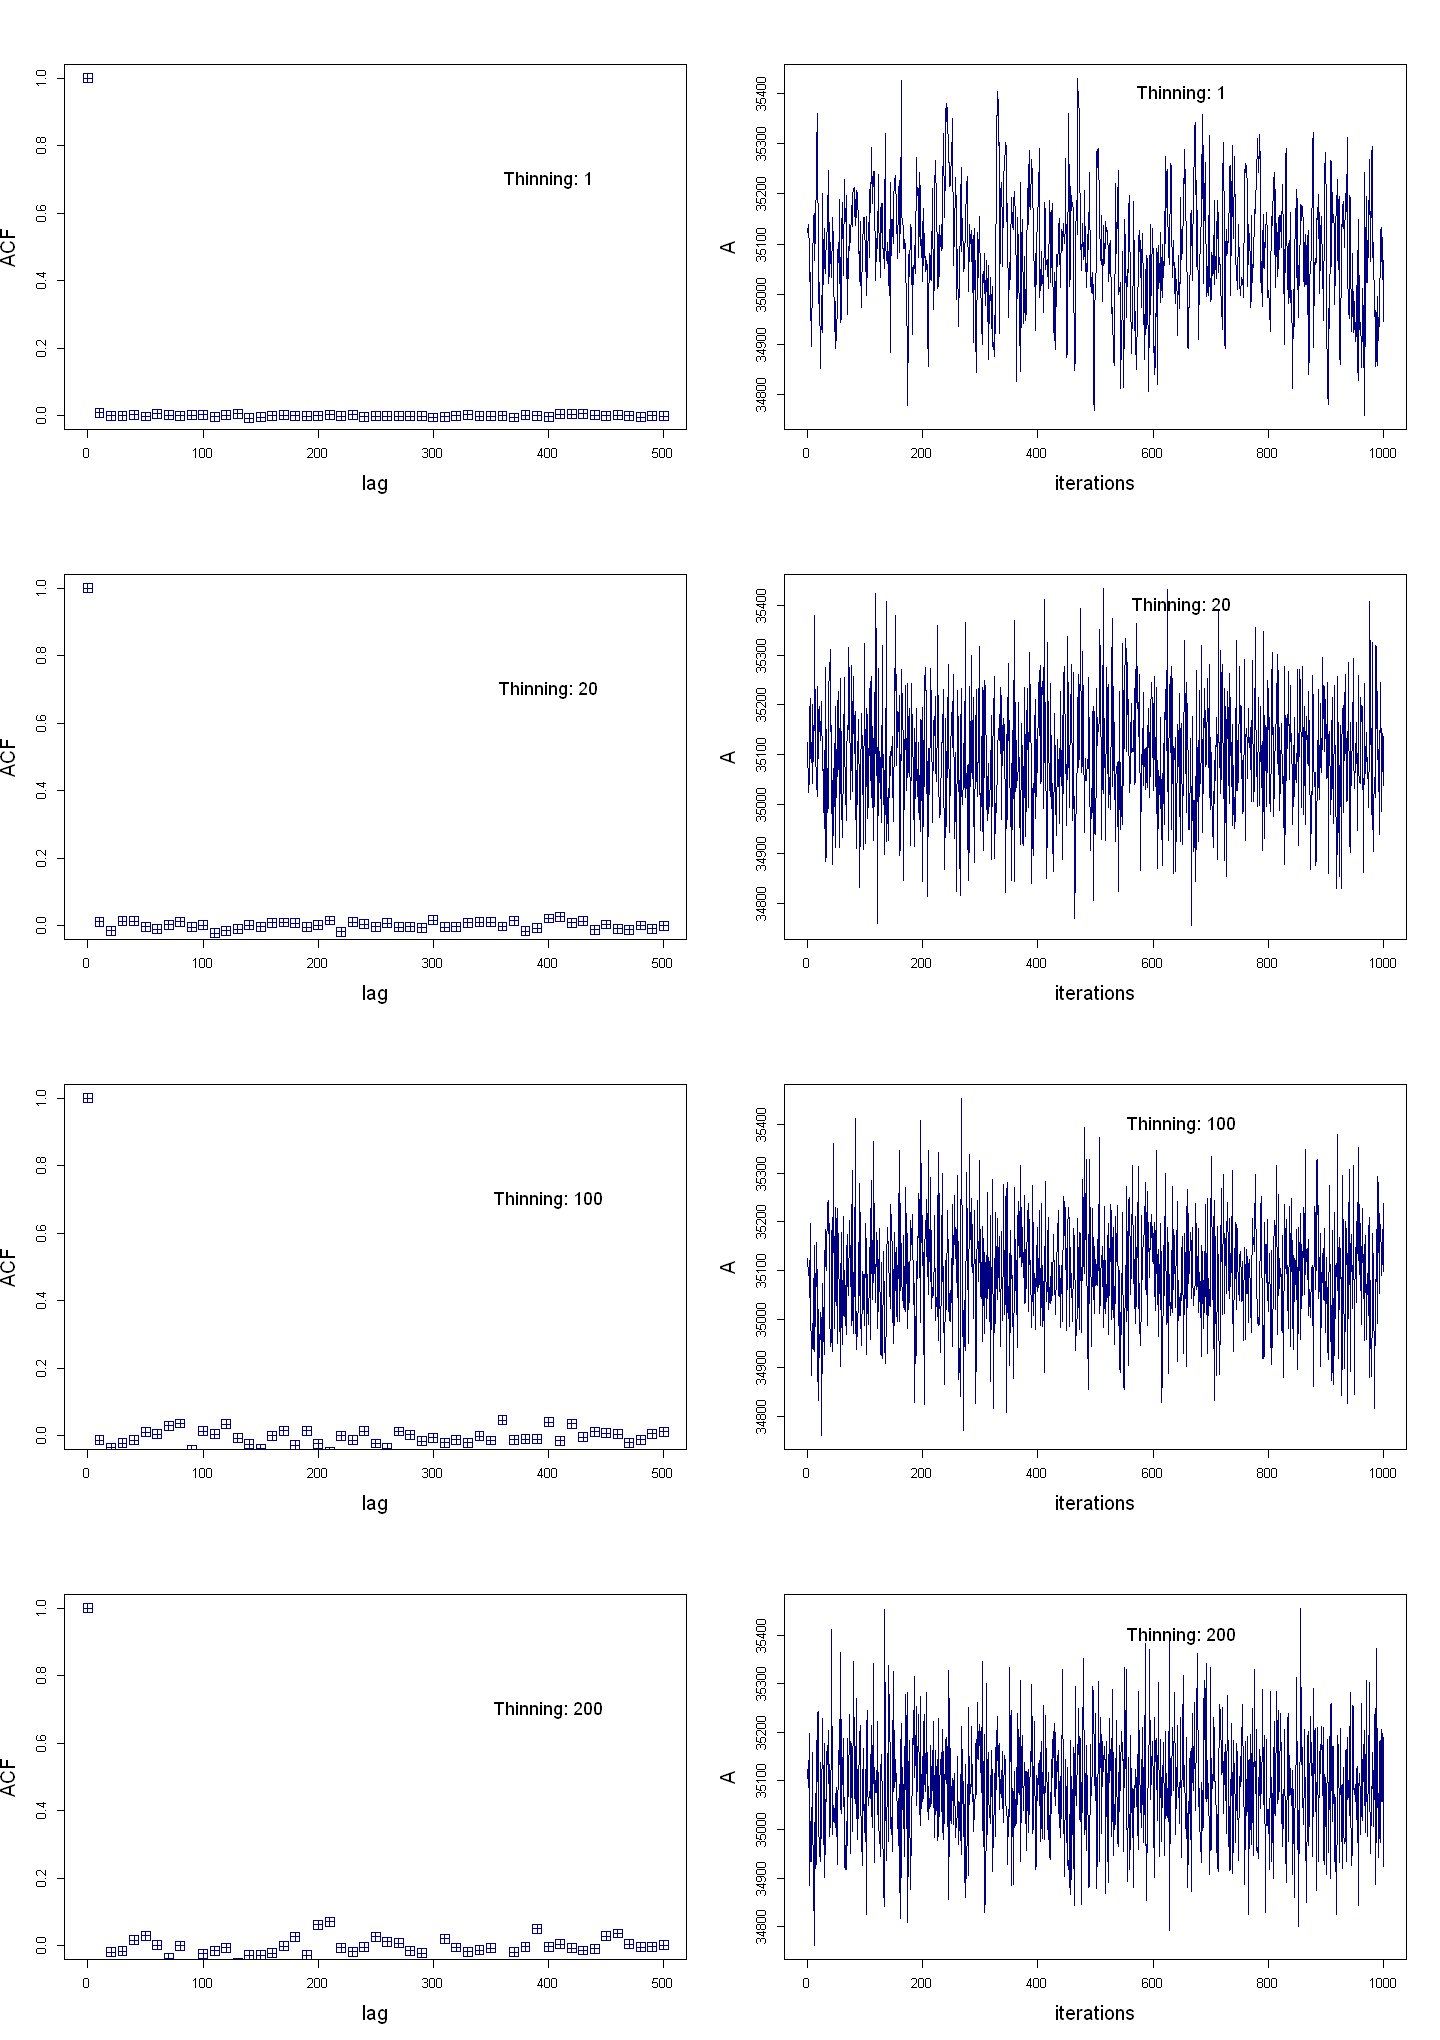

In [30]:
options(repr.plot.width=12, repr.plot.height=17)

par(mfrow=c(4,2))

thin.vals <- c(1,20,100,200)
# we consider the burn-in value of 2000 and fix it
burn <- 2000
update(jm , burn)
chain <- coda.samples(jm , variable.names=c("A","B","x0","w"), n.iter = 2e5, thin = 1)
chain.df <- as.data.frame(as.mcmc(chain))
  
for (thin in thin.vals){
   thinSel <- seq(from=1, to=nrow(chain.df), by=thin)
   thinchain.df <- chain.df[thinSel,]
   my.lags = seq(0,500,10)   
   y1 <- autocorr(as.mcmc(thinchain.df$A), lags=my.lags) # we consider it for param A
   plot(my.lags, y1, ylim=c(0,1),pch=12, col='navy',
        xlab='lag', ylab='ACF', cex=1.5,cex.lab=1.5)
   text(400,0.7, sprintf ("Thinning: %d", thin),cex=1.4)
   
   # plot the iterations(for over 1000 steps) and the movement of chain over parameter space 
   

   plot(1:1000,thinchain.df$A[1:1000] , type='l', col='navy',
        xlab='iterations', ylab='A', cex=1.5,cex.lab=1.5)
   text(650,35400, sprintf ("Thinning: %d", thin),cex=1.4) 
    
 
}


From the above graphs we see that both burn-in and thinning of chain doesn't have any effect on Auto-correlation. Auto-correlation or ACF(h) measures how closely the chain is correlated with itself h steps later. So, even small values of burn-in=10 and thin=10 can be used and that for a given parameter(here A) there is no correlation of its chain h steps later with those small values of thin-in and burn-in.  

 ## Spectra of Cs-137
 
 We are going to perform the same analysis to all the next peaks as the first one. 

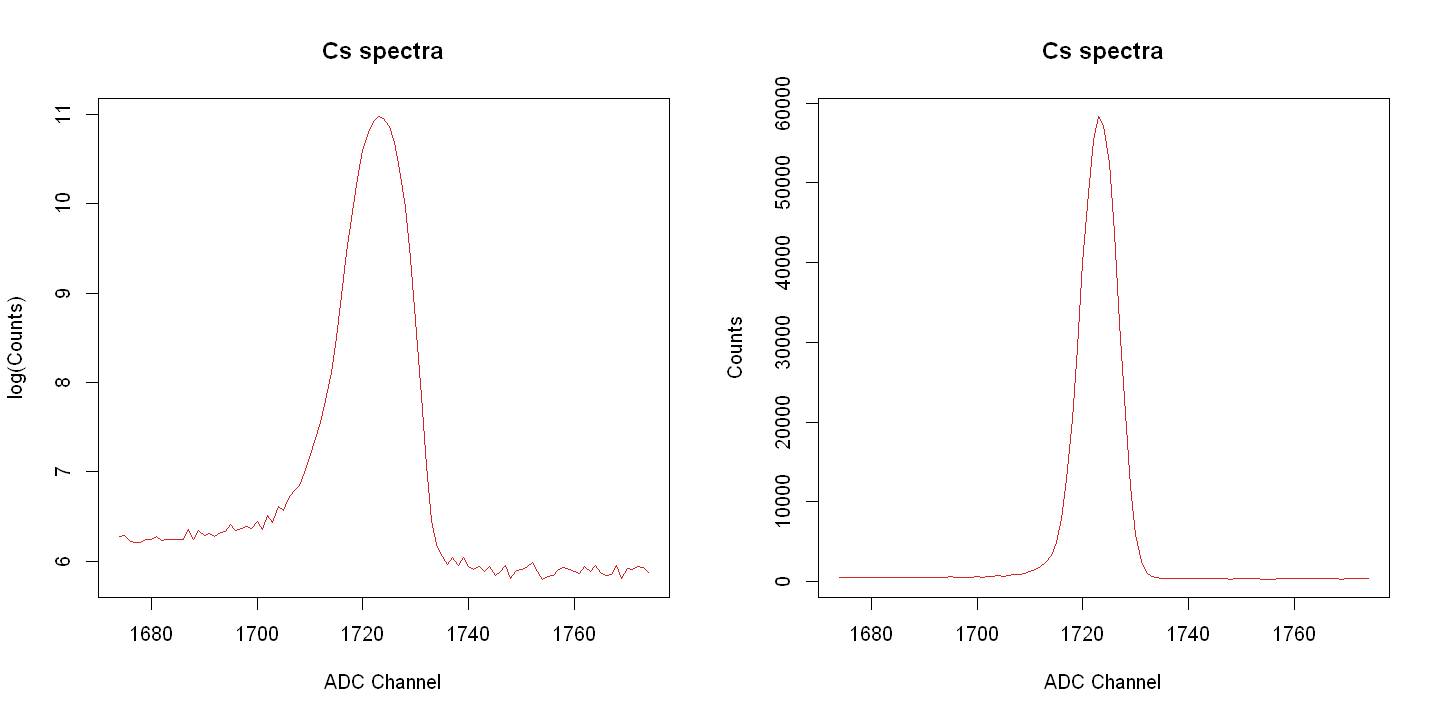

In [31]:
# Plotting only the spectra of Cs-137
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))

Cs.data <- NULL
Cs.data$x <- data$x[1675:1775] # 100 data points
Cs.data$y <- data$y[1675:1775] 

# log plot
plot(Cs.data$x, log(Cs.data$y), col='firebrick3', type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="Cs spectra")
# original plot
plot(Cs.data$x, Cs.data$y, col='firebrick3', type='l',xlab="ADC Channel",ylab="Counts",
     main="Cs spectra")


In [32]:
# Initial parameter values by inspection of the image
init <- NULL
init$A <- 50000
init$B <- 1000
init$w <- 10
init$x0 <- 1725

In [33]:
# set the seed 
set.seed(12345)

# Create the model and pass the parameters
jm <- jags.model("./Cs137.bug", Cs.data , init)

# Update the Markov chain (Burn -in)
update (jm , 4000)

Cs.chain <- coda.samples(jm , variable.names=c("A","B","x0","w"), n.iter = 2e5, thin = 100)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 4
   Total graph size: 922

Initializing model



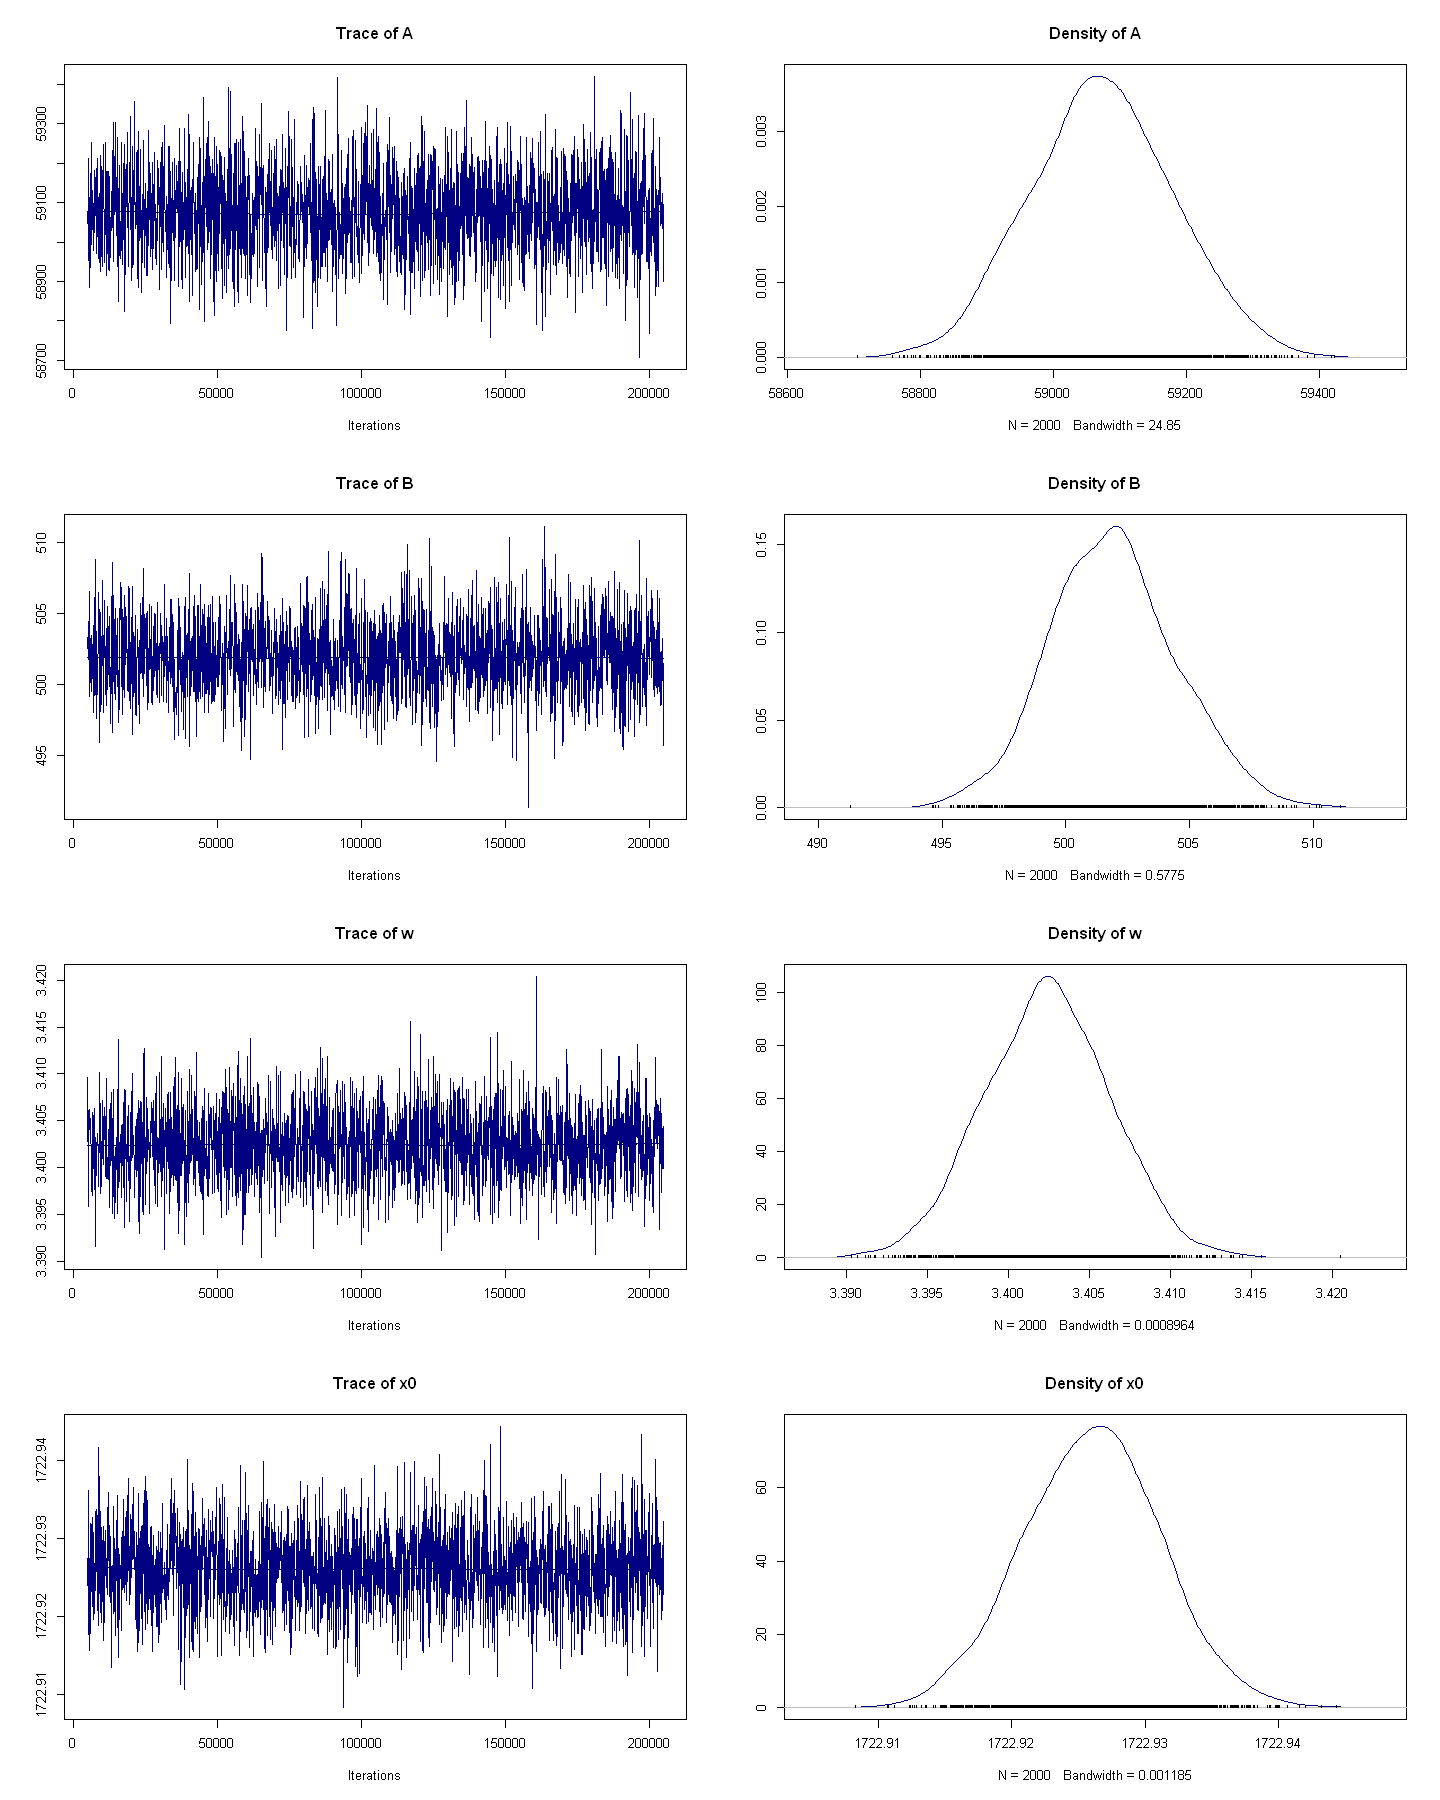

In [34]:
# plotting the chain, posterior distributions of the parameters
options(repr.plot.width=12, repr.plot.height=15)
plot(Cs.chain, col='navy')

In [35]:
summary(Cs.chain)


Iterations = 5100:205000
Thinning interval = 100 
Number of chains = 1 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean        SD  Naive SE Time-series SE
A  59073.637 1.072e+02 2.398e+00      2.398e+00
B    501.918 2.563e+00 5.732e-02      5.732e-02
w      3.402 3.867e-03 8.648e-05      8.648e-05
x0  1722.926 5.113e-03 1.143e-04      1.143e-04

2. Quantiles for each variable:

        2.5%     25%       50%       75%    97.5%
A  58869.504 59003.3 59072.520 59146.998 59285.87
B    496.949   500.2   501.859   503.517   507.13
w      3.395     3.4     3.402     3.405     3.41
x0  1722.916  1722.9  1722.926  1722.929  1722.94


In [36]:
# Format our chain
chain.df <- as.data.frame(as.mcmc(Cs.chain))

# A Quantitative way for correlation of parameters
cat(sprintf ("\n Correlation matrix : \n"))
print(cor(chain.df))


 Correlation matrix : 
             A           B           w          x0
A   1.00000000  0.05260650 -0.55875555  0.01773538
B   0.05260650  1.00000000 -0.17311687  0.04341506
w  -0.55875555 -0.17311687  1.00000000 -0.06144216
x0  0.01773538  0.04341506 -0.06144216  1.00000000


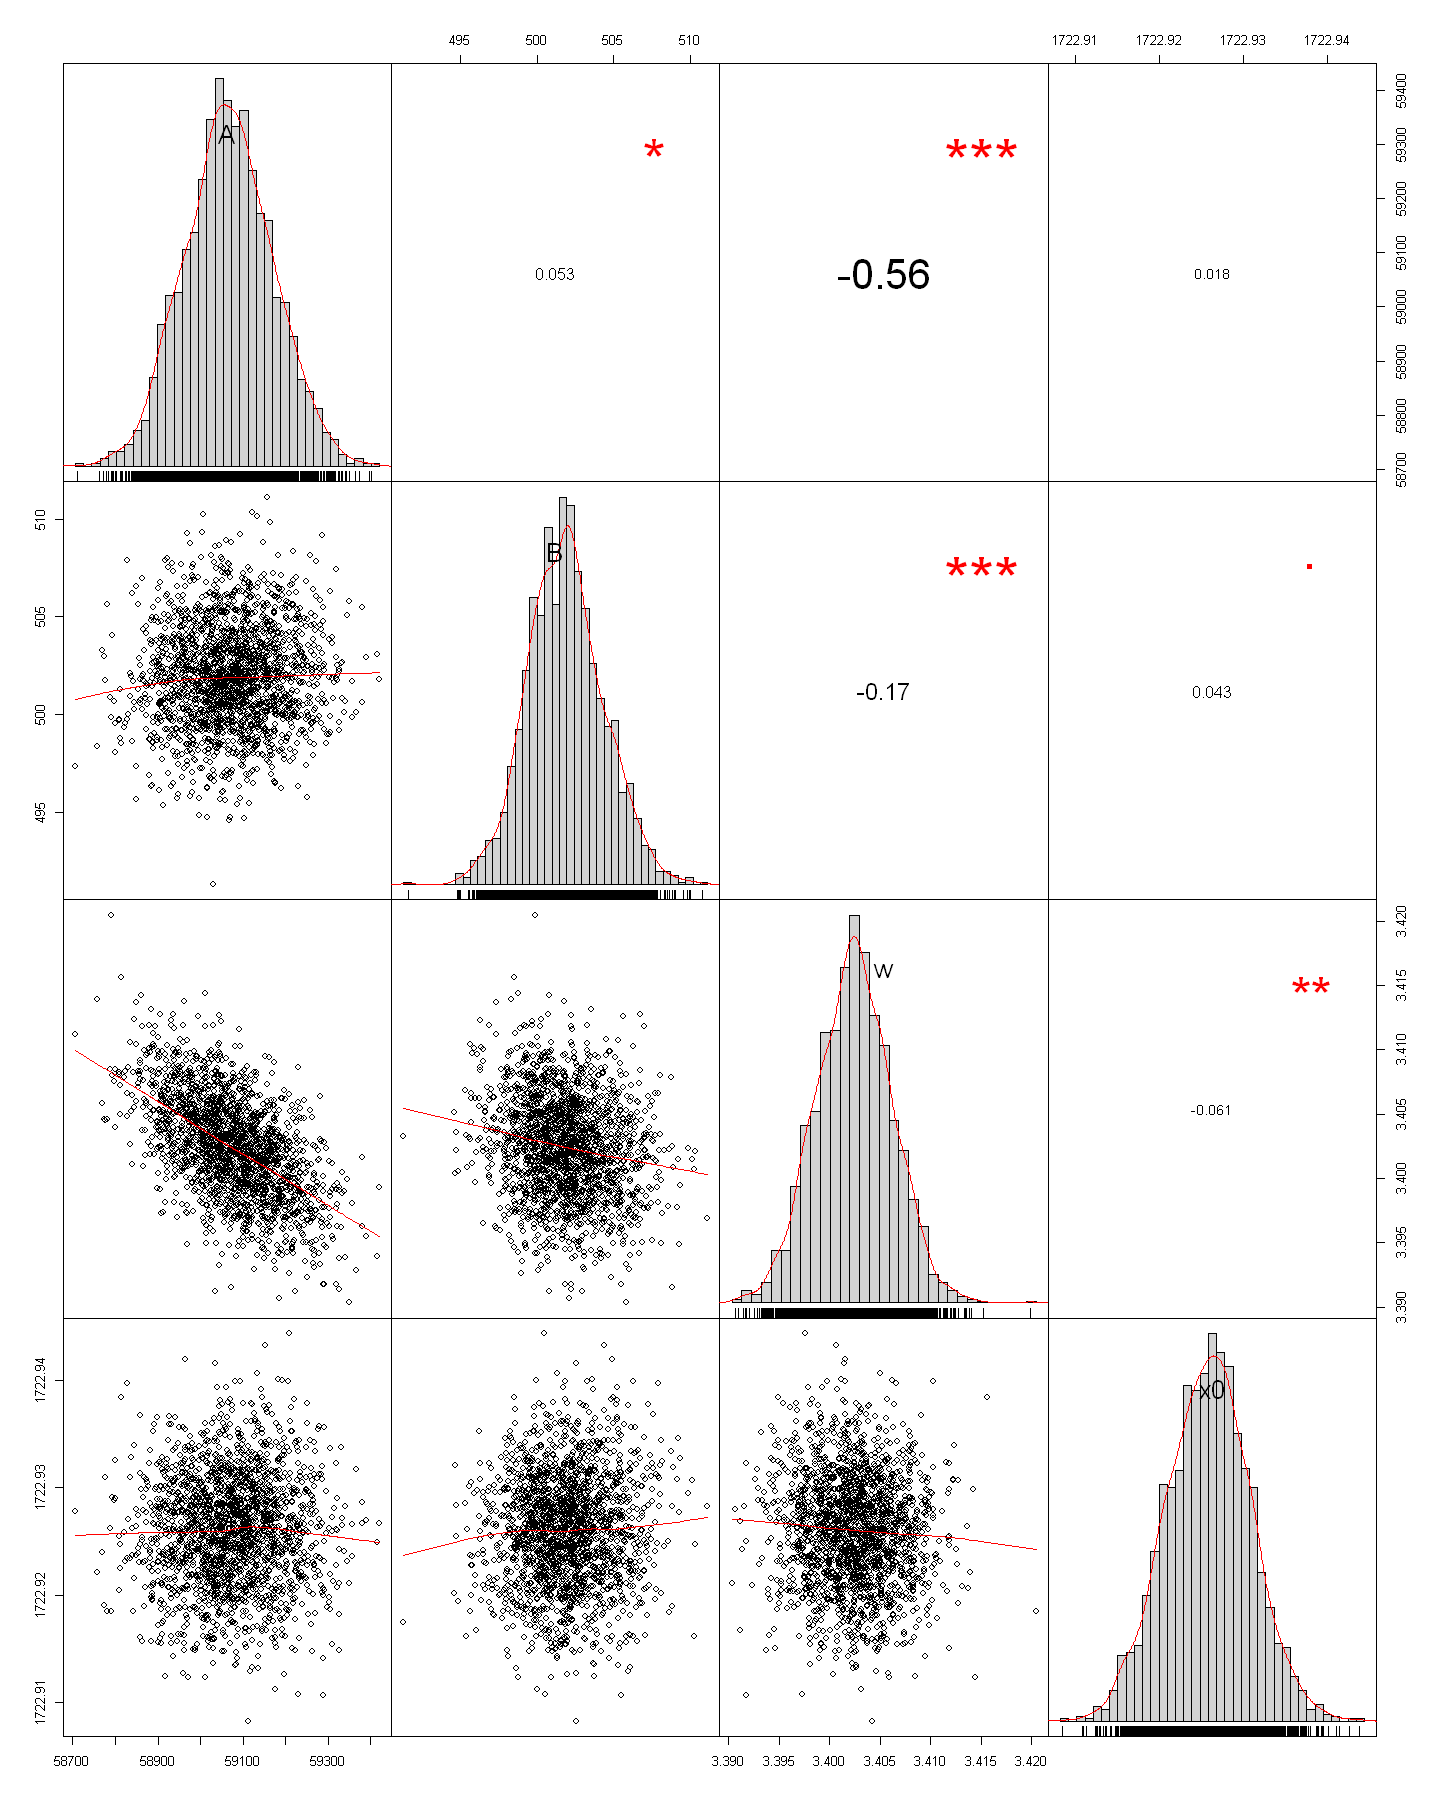

In [37]:
chart.Correlation(chain.df, histogram = T, pch= 19)

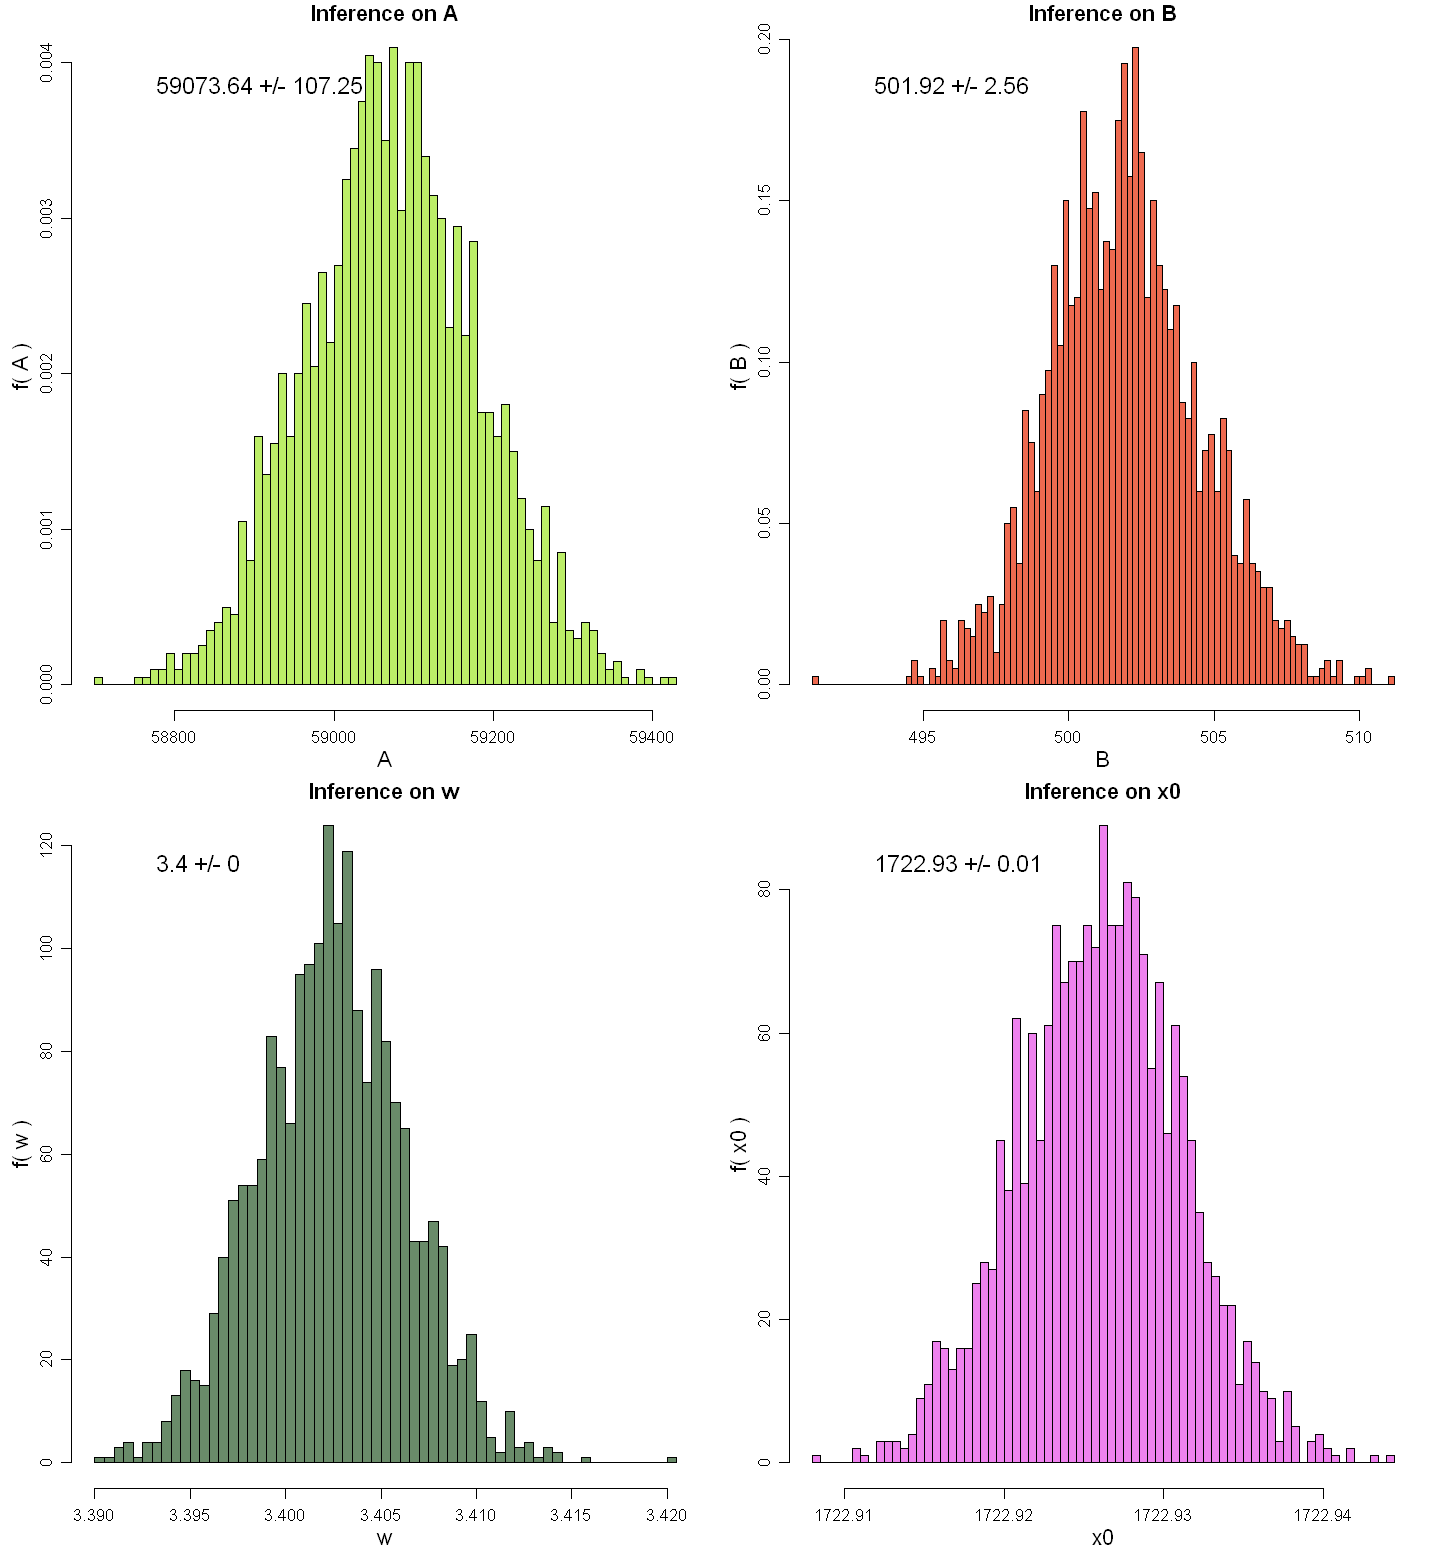

In [38]:
histogram.plot(Cs.chain)

In [39]:
Cs.estimates <- Estimates(Cs.chain)

Estimates for the posterior distributions of parameters are:
 param: mean +/- sd
 A : 59073.64 +/- 107.2476
 B : 501.9175 +/- 2.563243
 w : 3.402431 +/- 0.003867287
 x0 : 1722.926 +/- 0.005113189

95% CI for each posterior dist. of parameters:
 param: lower_limit - upper_limit
 A : 58869.5 - 59285.87
 B : 496.9489 - 507.1304
 w : 3.394846 - 3.409786
 x0 : 1722.916 - 1722.936

In [40]:
Cs.estimates

$A
[1] 59073.64

$B
[1] 501.9175

$w
[1] 3.402431

$x0
[1] 1722.926

## Spectre of first peak Co-60

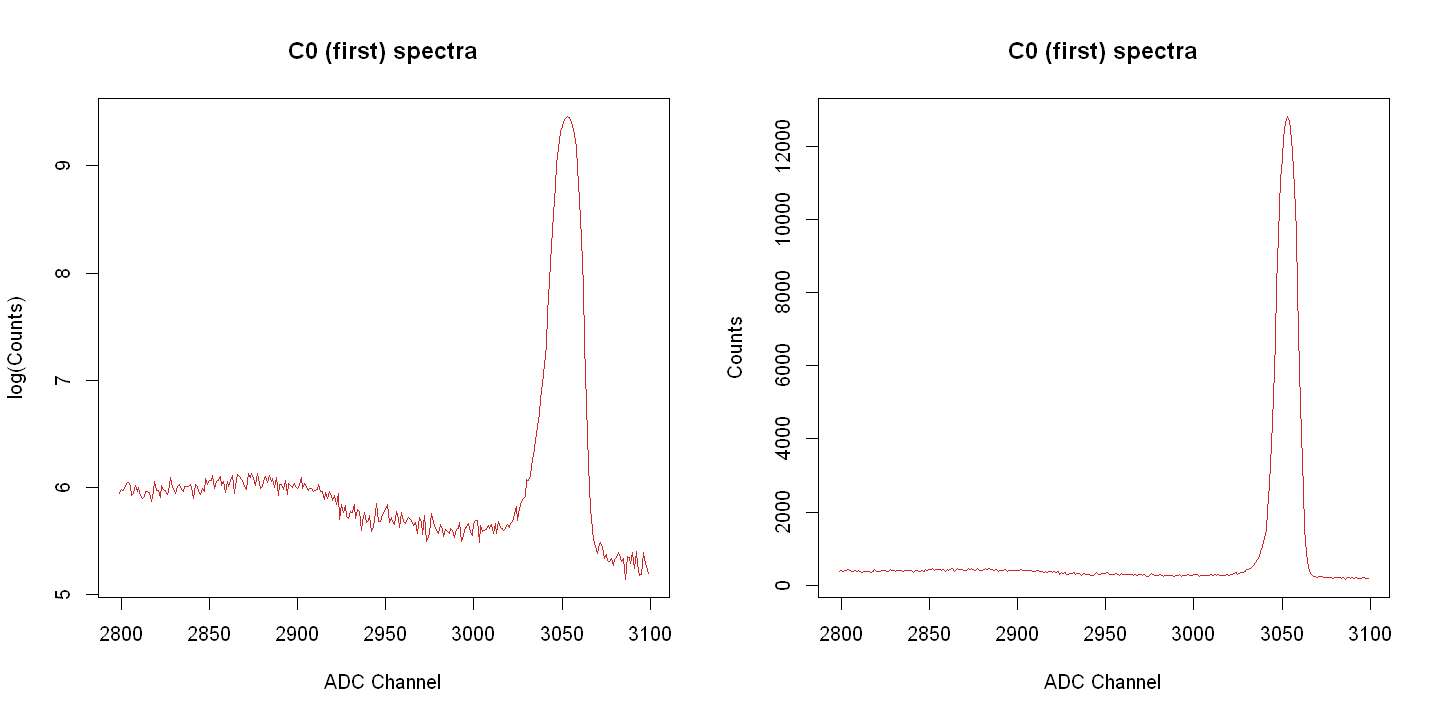

In [41]:
# Plotting only the spectra of Cs-137
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))

C01.data <- NULL
C01.data$x <- data$x[2800:3100]
C01.data$y <- data$y[2800:3100]

# log plot
plot(C01.data$x, log(C01.data$y), col='firebrick3', type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="C0 (first) spectra")
# original plot
plot(C01.data$x, C01.data$y, col='firebrick3', type='l',xlab="ADC Channel",ylab="Counts",
     main="C0 (first) spectra")


In [42]:
# Initial parameter values by inspection of the image
init <- NULL
init$A <- 10000
init$B <- 500
init$w <- 10
init$x0 <- 3050

In [43]:
# set the seed 
set.seed(12345)

# Create the model and pass the parameters
jm <- jags.model("./C0.1.bug", C01.data , init)

# Update the Markov chain (Burn -in)
update (jm , 4000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 301
   Unobserved stochastic nodes: 4
   Total graph size: 2722

Initializing model



In [44]:
Co1.chain <- coda.samples(jm , variable.names=c("A","B","x0","w"), n.iter = 2e5, thin = 100)

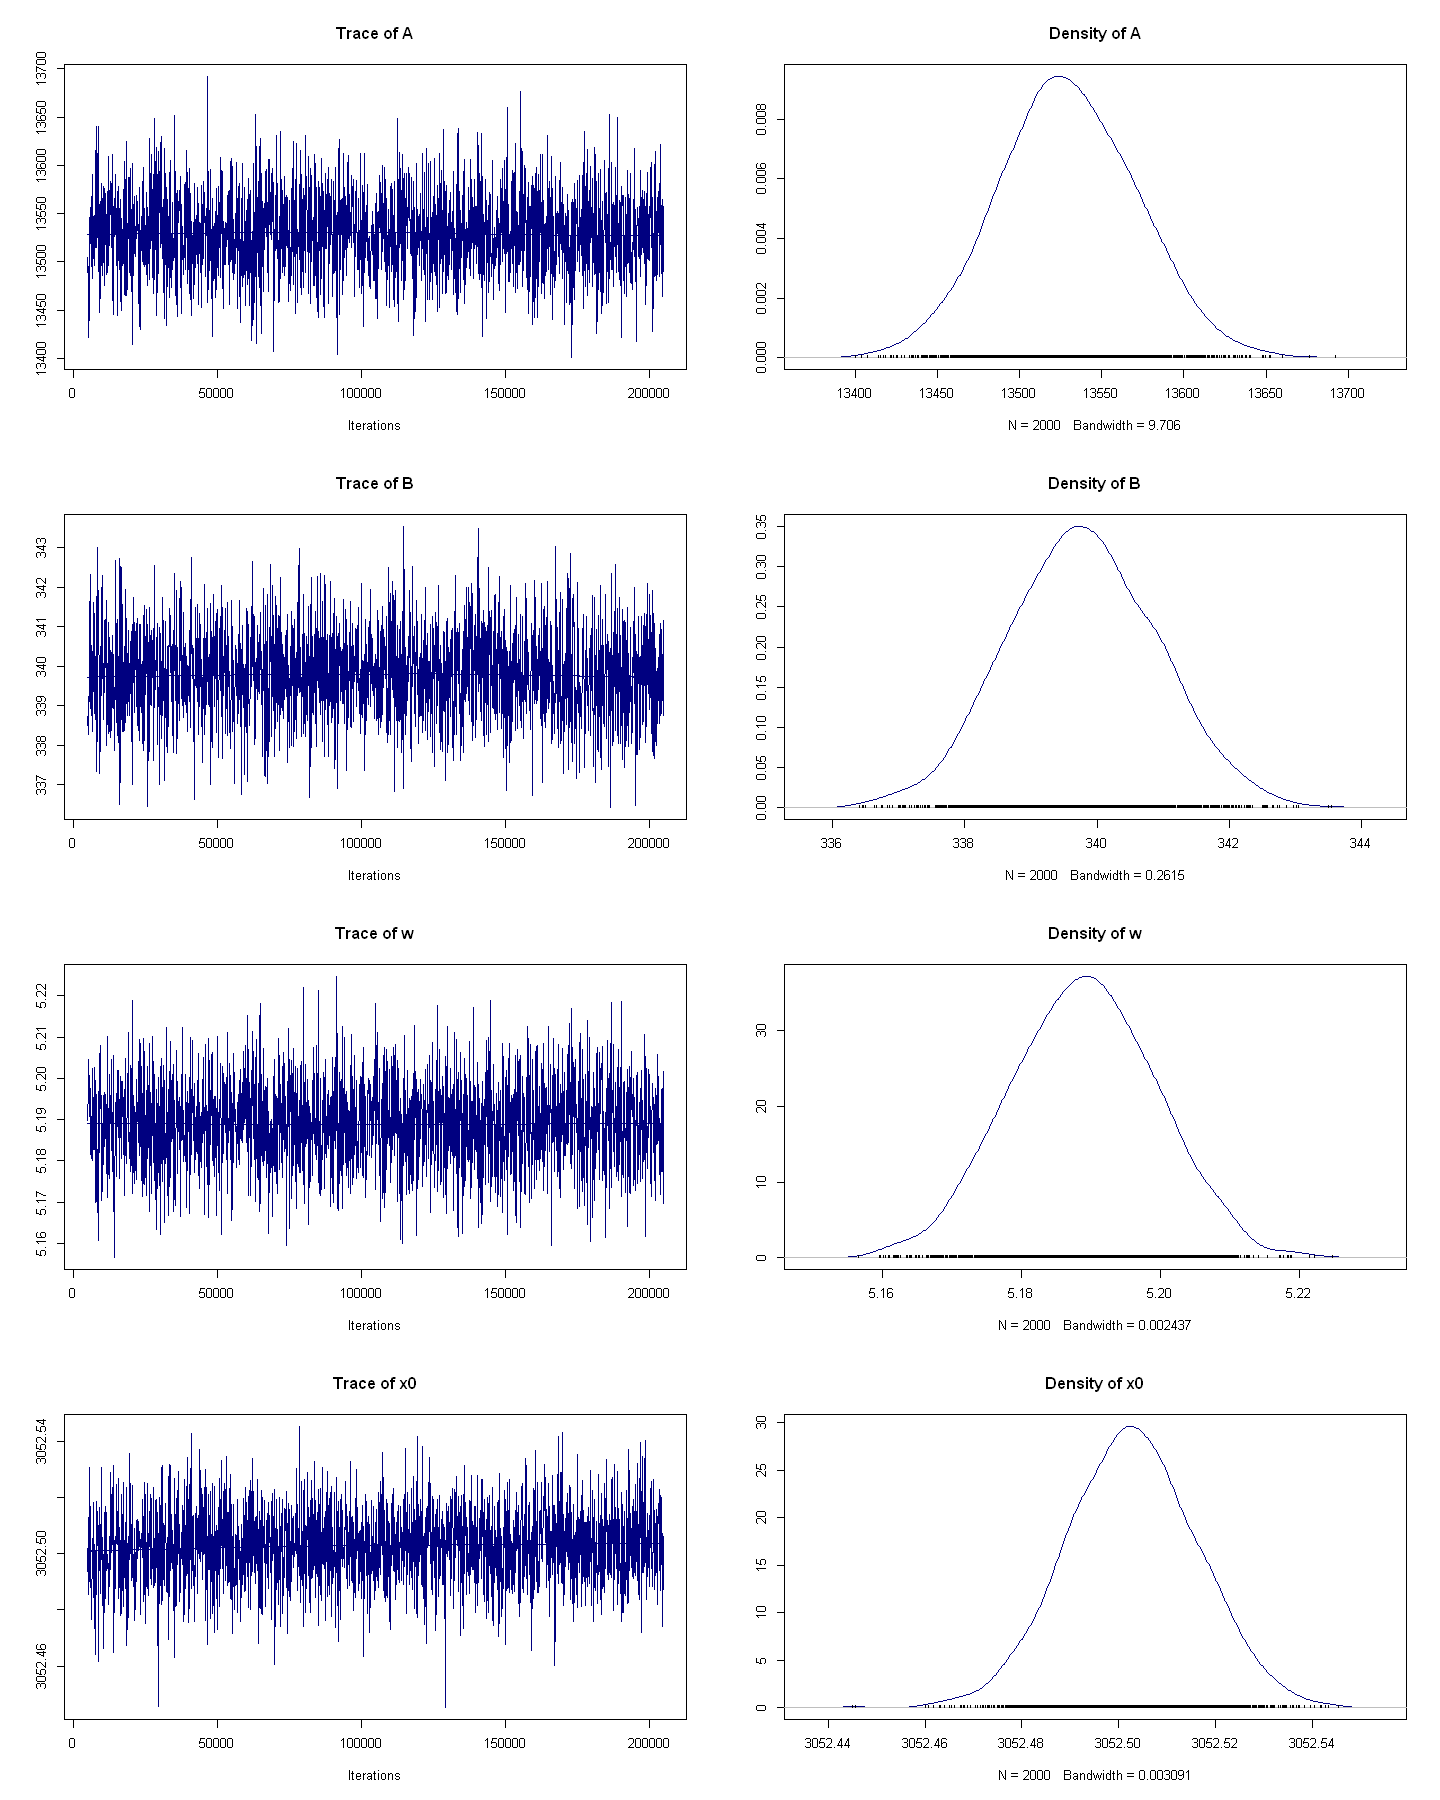

In [45]:
# plotting the chain, posterior distributions of the parameters
options(repr.plot.width=12, repr.plot.height=15)
plot(Co1.chain, col='navy')


 Correlation matrix : 
             A           B          w          x0
A   1.00000000 -0.00057596 -0.6053697  0.10181287
B  -0.00057596  1.00000000 -0.1259481  0.03133791
w  -0.60536973 -0.12594805  1.0000000 -0.11580775
x0  0.10181287  0.03133791 -0.1158077  1.00000000


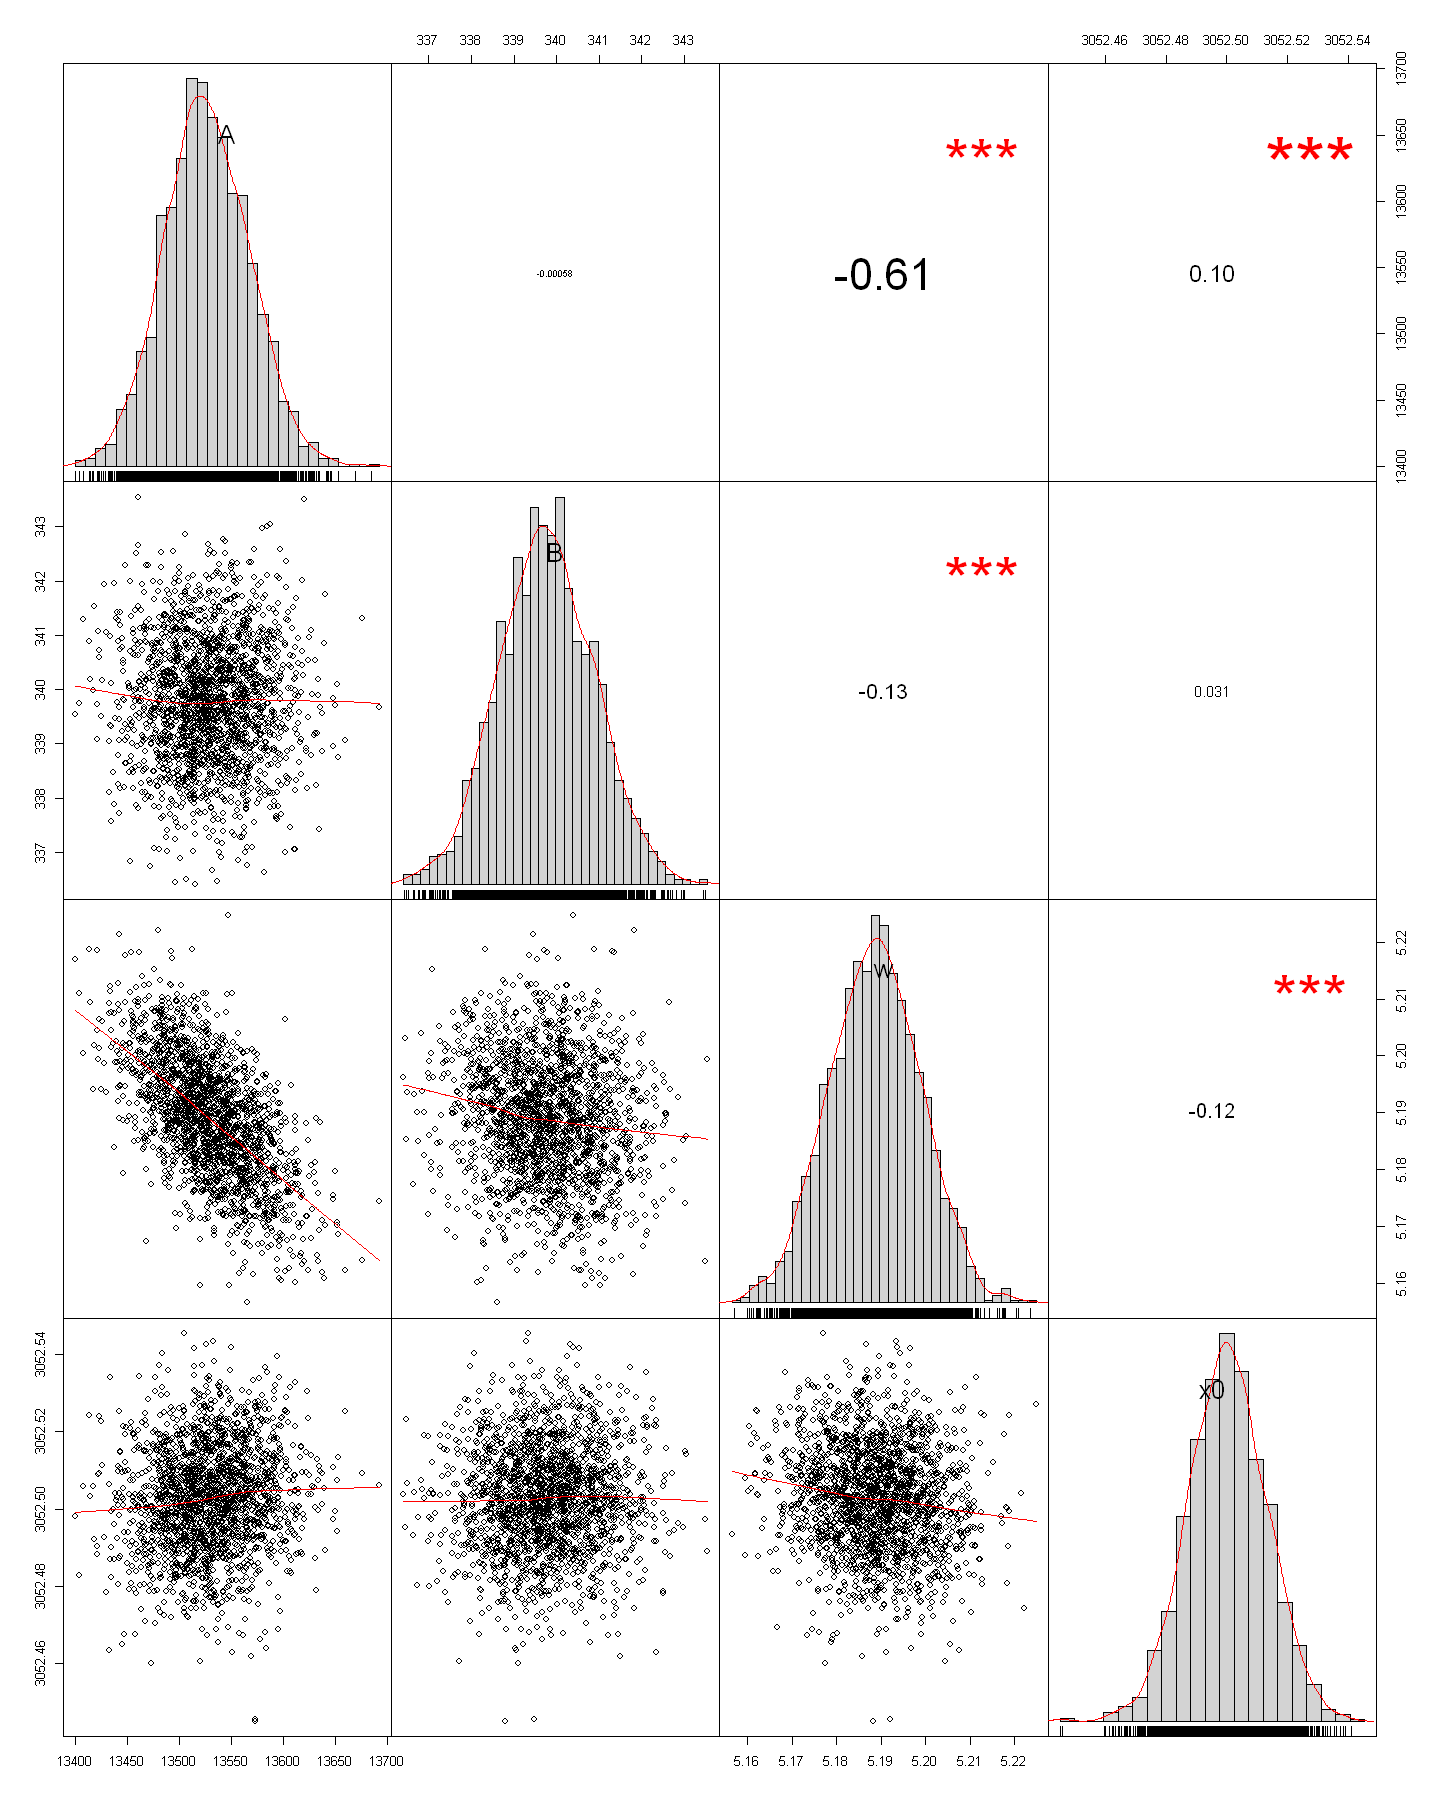

In [46]:
# Format our chain
chain.df <- as.data.frame(as.mcmc(Co1.chain))

# A Quantitative way for correlation of parameters
cat(sprintf ("\n Correlation matrix : \n"))
print(cor(chain.df))
chart.Correlation(chain.df, histogram = T, pch= 19)


Iterations = 5100:205000
Thinning interval = 100 
Number of chains = 1 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  13529.582 41.92864 0.9375528      0.9375528
B    339.781  1.12809 0.0252250      0.0252250
w      5.189  0.01051 0.0002351      0.0002277
x0  3052.503  0.01358 0.0003036      0.0003302

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  13447.344 13501.552 13528.406 13557.661 13612.079
B    337.610   339.012   339.768   340.536   342.030
w      5.168     5.182     5.189     5.196     5.209
x0  3052.476  3052.494  3052.503  3052.511  3052.529


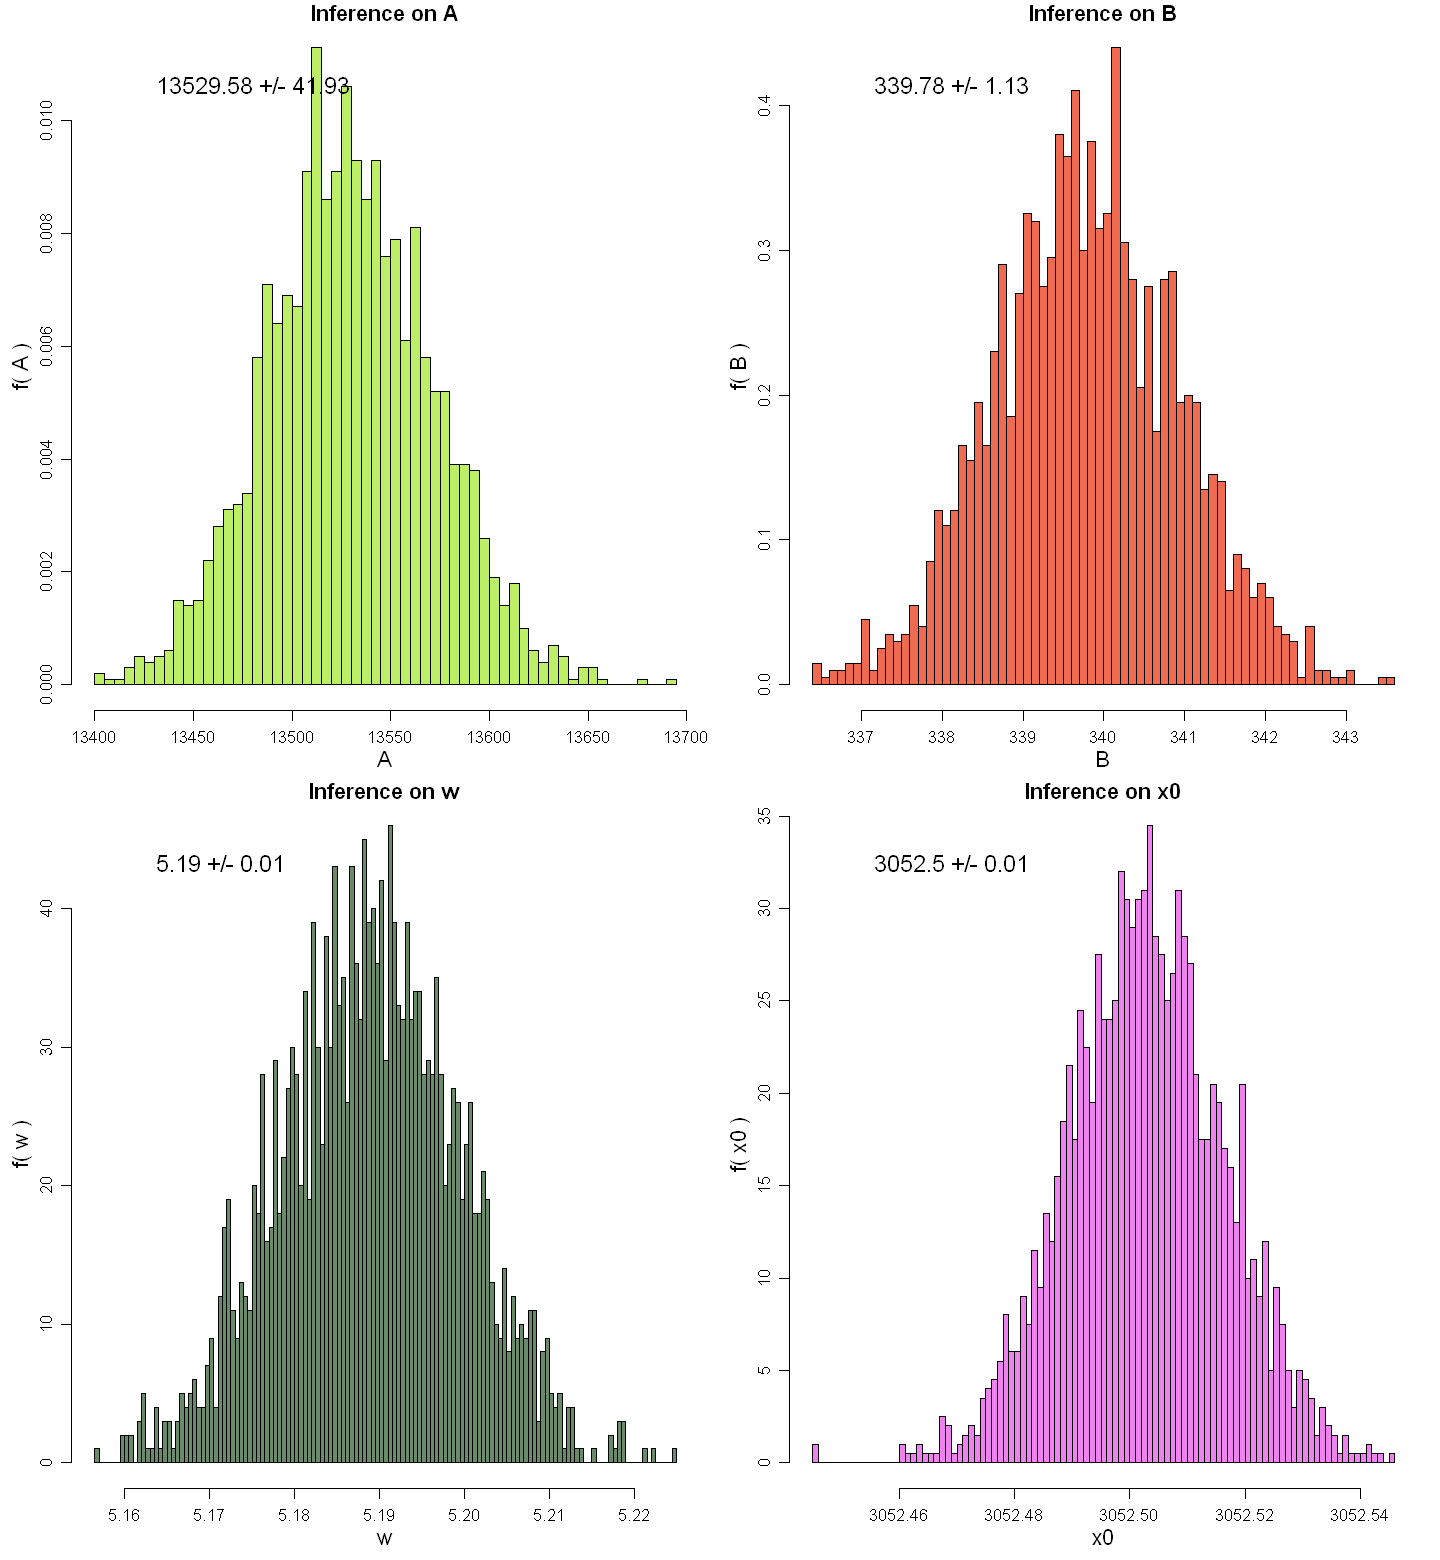

In [47]:
summary(Co1.chain)
histogram.plot(Co1.chain)

In [48]:
Co1.estimates <- Estimates(Co1.chain)

Estimates for the posterior distributions of parameters are:
 param: mean +/- sd
 A : 13529.58 +/- 41.92864
 B : 339.7811 +/- 1.128094
 w : 5.188908 +/- 0.01051301
 x0 : 3052.503 +/- 0.01357855

95% CI for each posterior dist. of parameters:
 param: lower_limit - upper_limit
 A : 13447.34 - 13612.08
 B : 337.6102 - 342.0298
 w : 5.168419 - 5.209289
 x0 : 3052.476 - 3052.529

## Spectre of second peak of C0

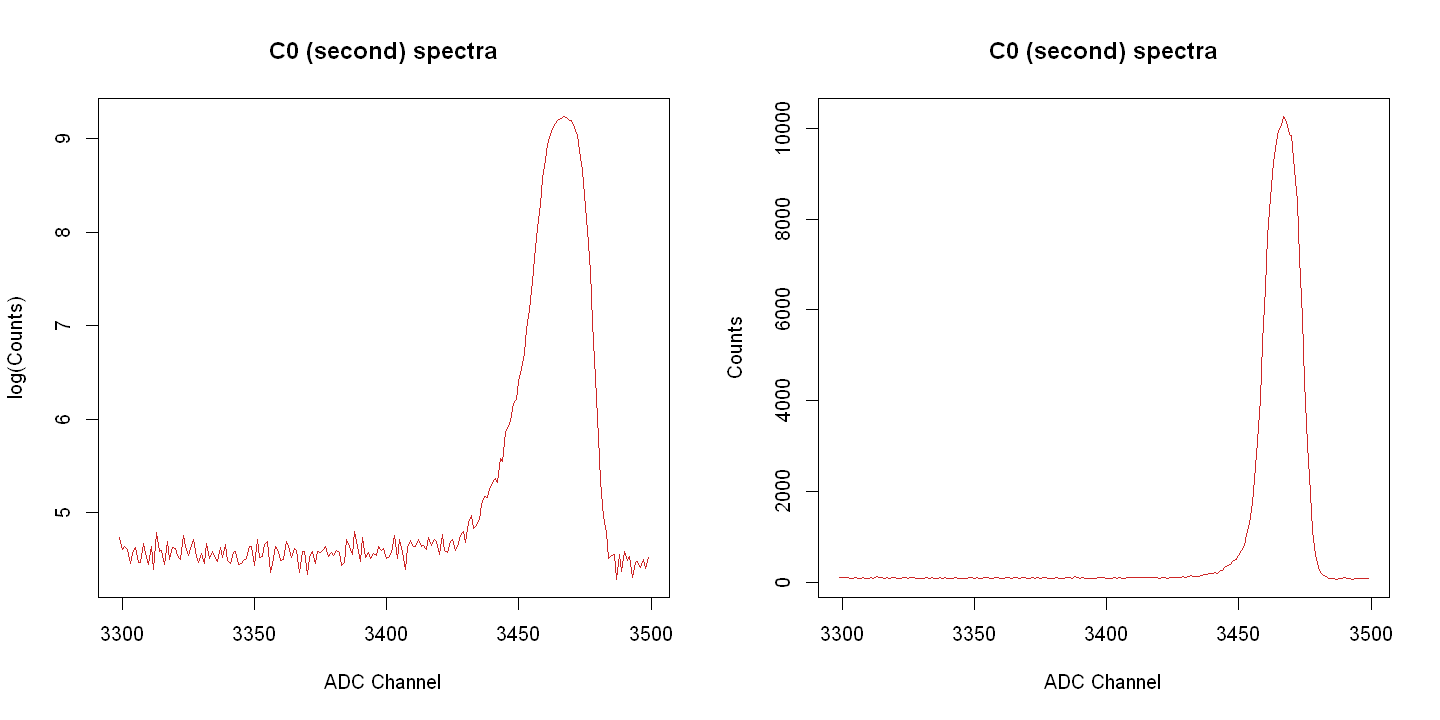

In [50]:
# Plotting only the spectra of Cs-137
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))

C02.data <- NULL
C02.data$x <- data$x[3300:3500]
C02.data$y <- data$y[3300:3500]

# log plot
plot(C02.data$x, log(C02.data$y), col='firebrick3', type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="C0 (second) spectra")
# original plot
plot(C02.data$x, (C02.data$y), col='firebrick3', type='l',xlab="ADC Channel",ylab="Counts",
     main="C0 (second) spectra")


In [51]:
# Initial parameter values by inspection of the image
init <- NULL
init$A <- 10000
init$B <- 200
init$w <- 10
init$x0 <- 3500

# set the seed 
set.seed(12345)

# Create the model and pass the parameters
jm <- jags.model("./C0.2.bug", C02.data , init)

# Update the Markov chain (Burn -in)
update (jm , 4000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 201
   Unobserved stochastic nodes: 4
   Total graph size: 1822

Initializing model



In [52]:
Co2.chain <- coda.samples(jm , variable.names=c("A","B","x0","w"), n.iter = 2e5, thin = 100)

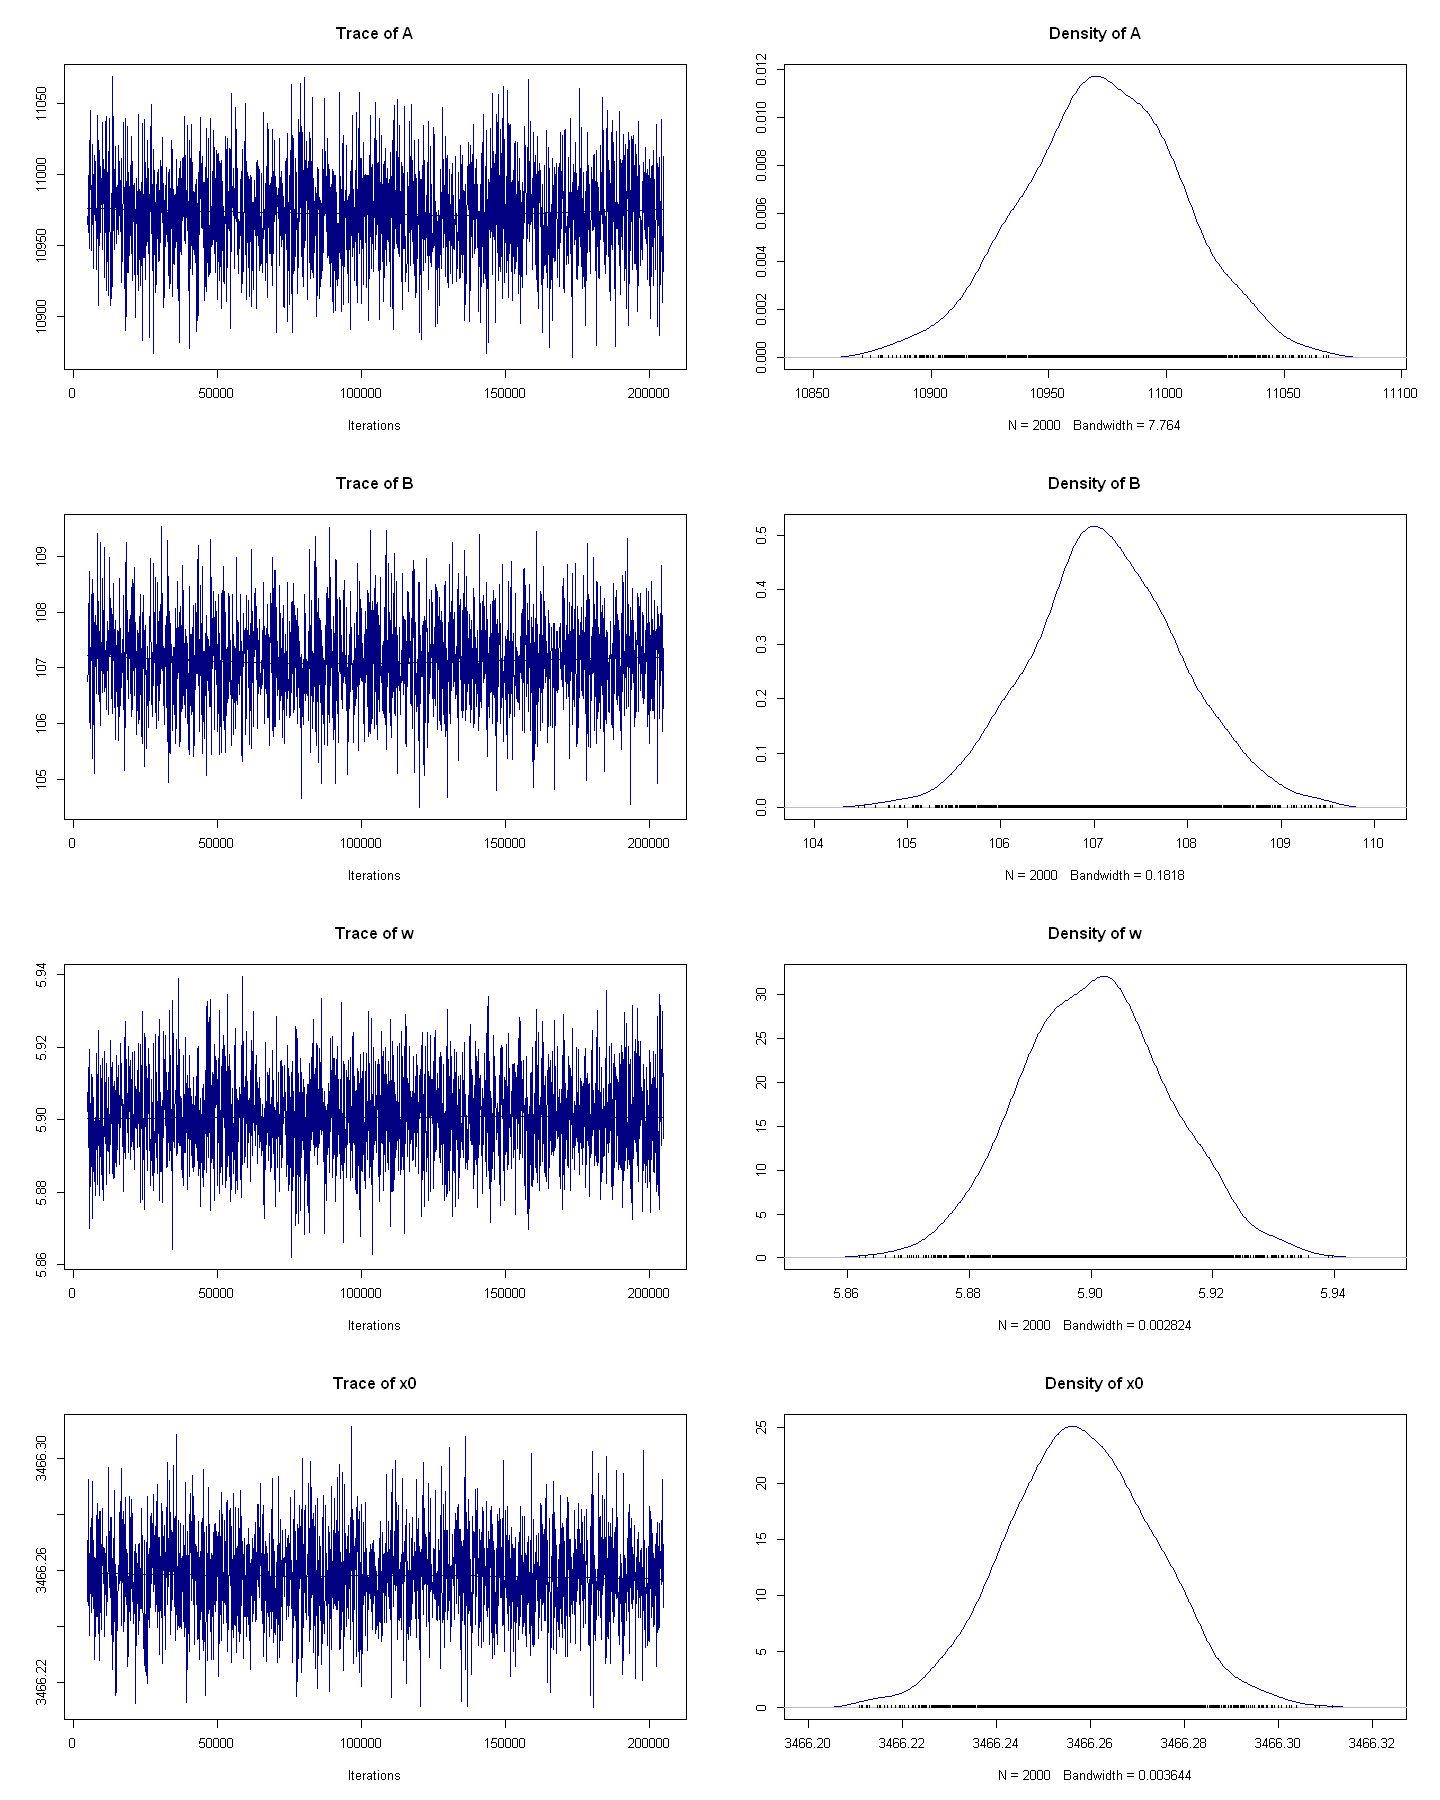

In [53]:
# plotting the chain, posterior distributions of the parameters
options(repr.plot.width=12, repr.plot.height=15)
plot(Co2.chain, col='navy')


 Correlation matrix : 
            A           B           w          x0
A   1.0000000  0.08641310 -0.60071459  0.06758710
B   0.0864131  1.00000000 -0.18913522  0.06033404
w  -0.6007146 -0.18913522  1.00000000 -0.08977913
x0  0.0675871  0.06033404 -0.08977913  1.00000000


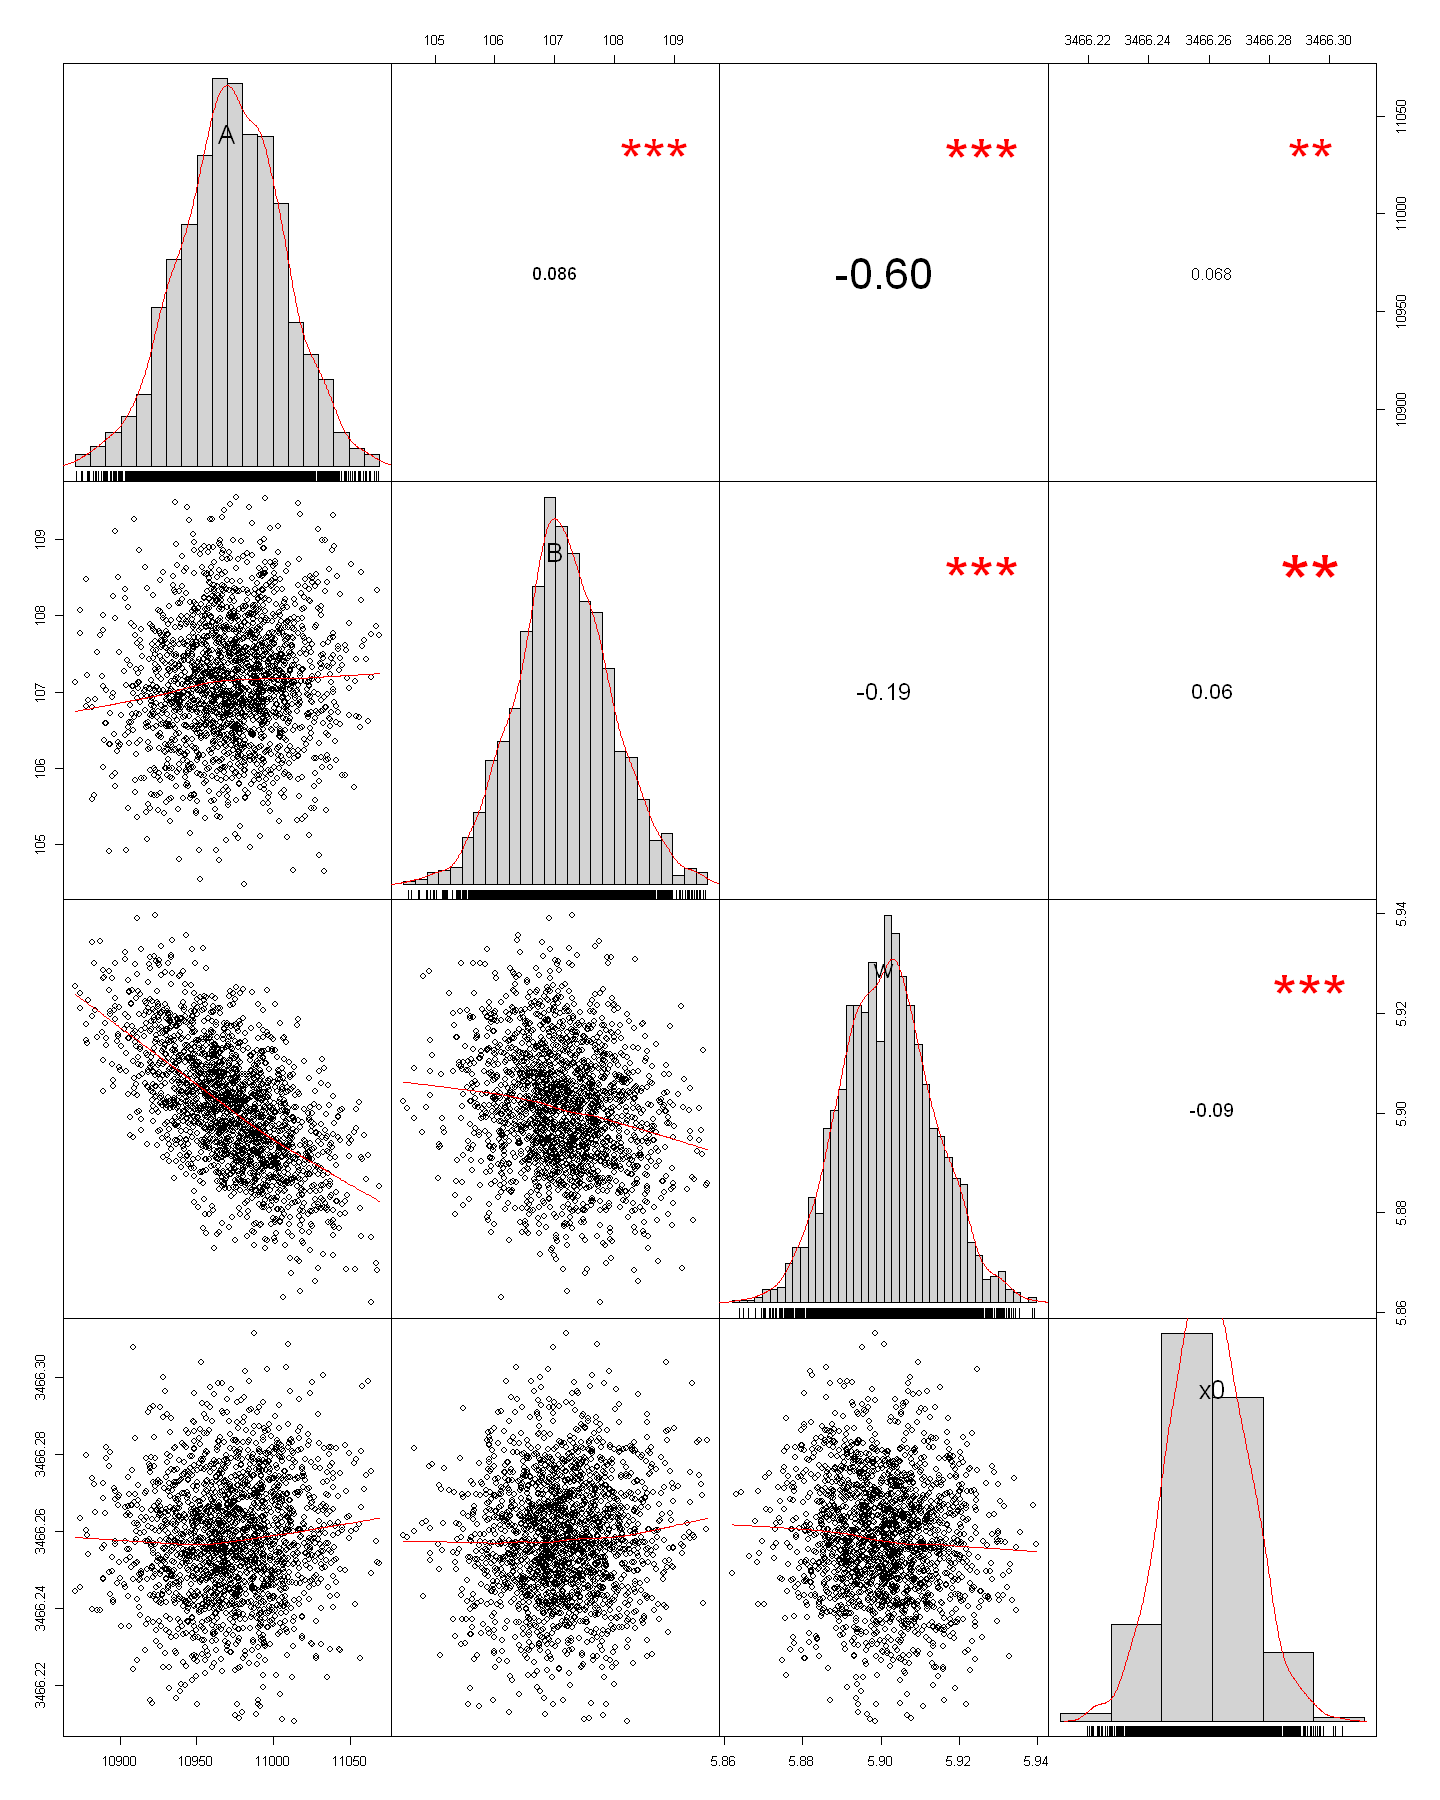

In [54]:
# Format our chain
chain.df <- as.data.frame(as.mcmc(Co2.chain))

# A Quantitative way for correlation of parameters
cat(sprintf ("\n Correlation matrix : \n"))
print(cor(chain.df))

# A visual understanding of correlation
chart.Correlation(chain.df, histogram = T, pch= 19)


Iterations = 5100:205000
Thinning interval = 100 
Number of chains = 1 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  10972.665 33.73950 0.7544382      0.7544382
B    107.129  0.81148 0.0181451      0.0168913
w      5.901  0.01218 0.0002724      0.0002514
x0  3466.258  0.01572 0.0003516      0.0003516

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  10905.569 10950.165 10973.035 10995.049 11038.008
B    105.564   106.606   107.113   107.657   108.787
w      5.878     5.892     5.901     5.909     5.925
x0  3466.228  3466.248  3466.257  3466.269  3466.289


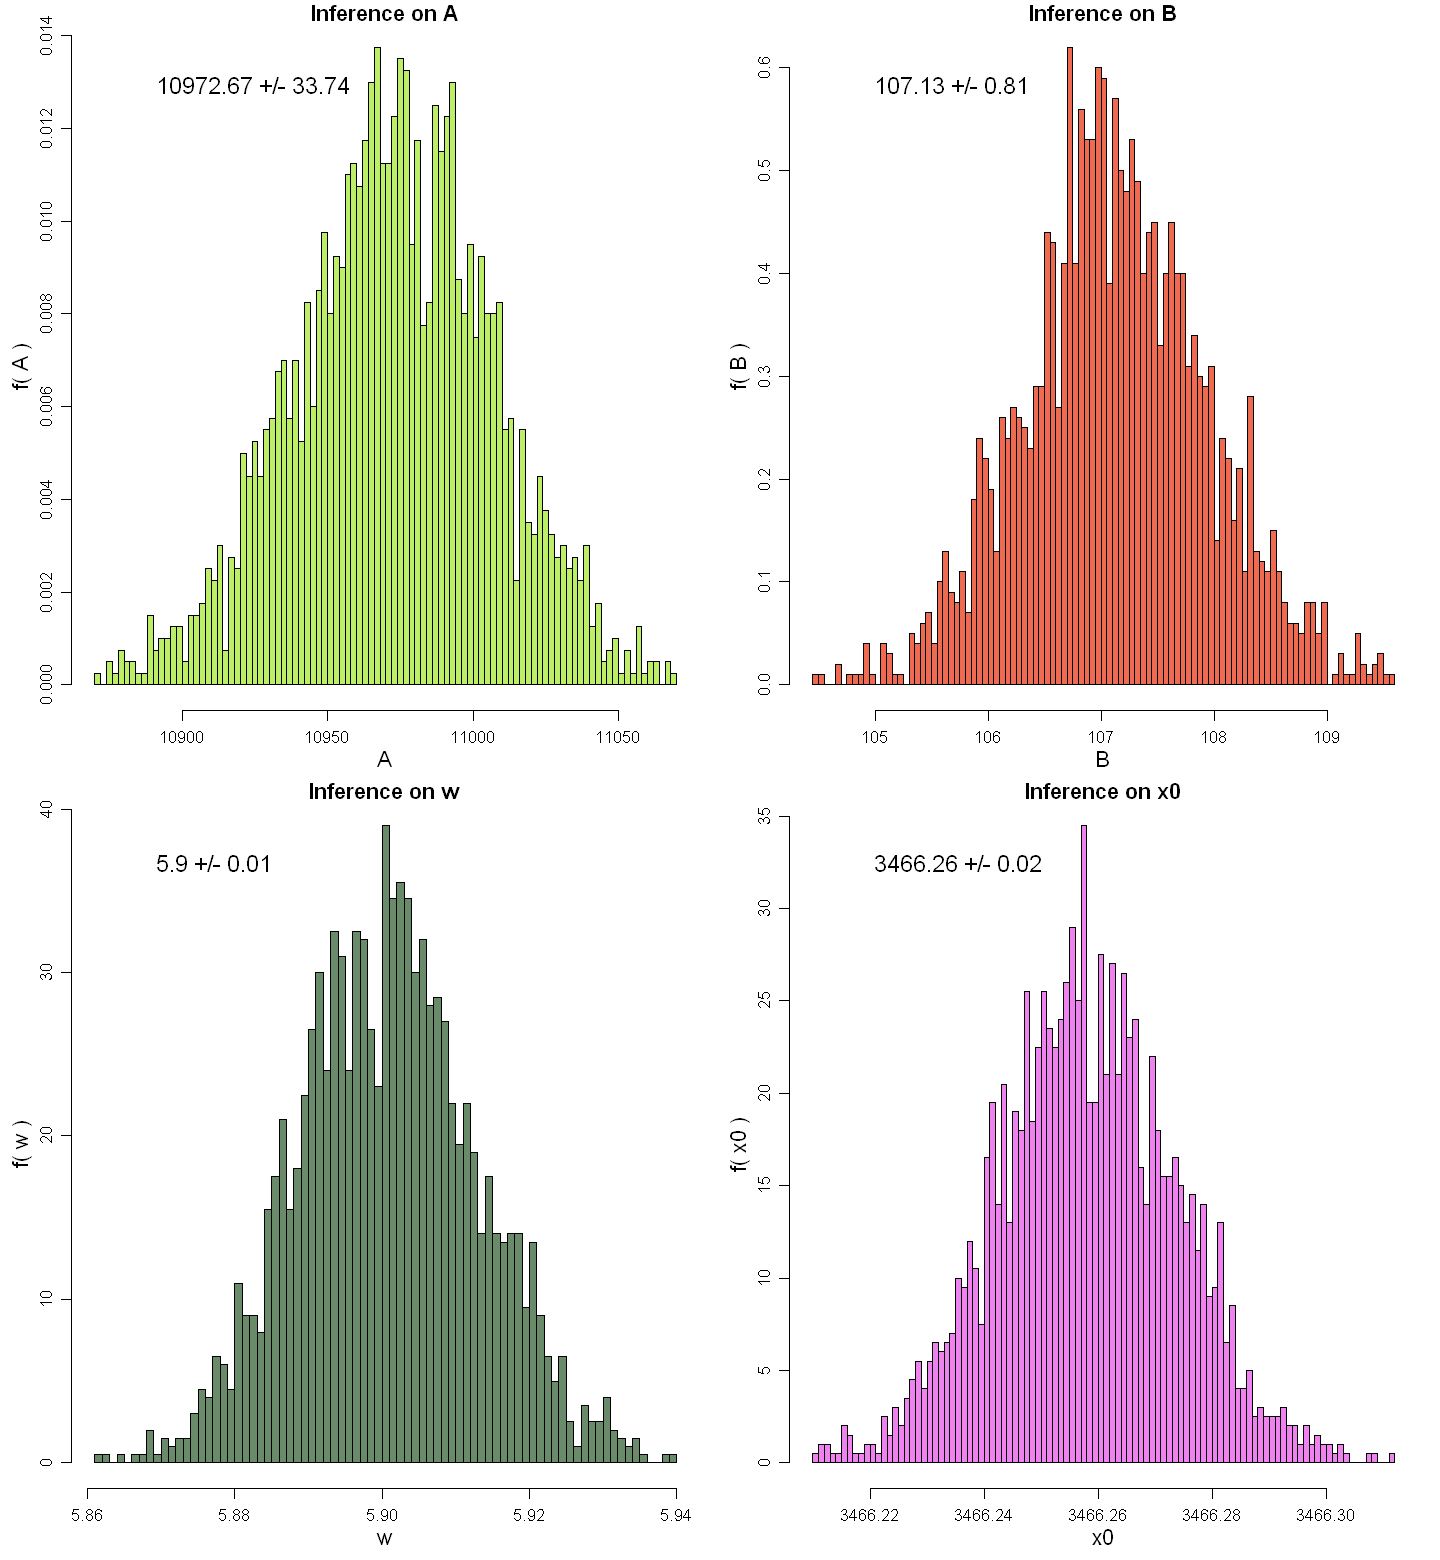

In [55]:
summary(Co2.chain)
histogram.plot(Co2.chain)

In [56]:
Co2.estimates <- Estimates(Co2.chain)

Estimates for the posterior distributions of parameters are:
 param: mean +/- sd
 A : 10972.67 +/- 33.7395
 B : 107.1292 +/- 0.8114756
 w : 5.900811 +/- 0.01218177
 x0 : 3466.258 +/- 0.01572269

95% CI for each posterior dist. of parameters:
 param: lower_limit - upper_limit
 A : 10905.57 - 11038.01
 B : 105.5642 - 108.7874
 w : 5.877635 - 5.924543
 x0 : 3466.228 - 3466.289

In general we can see the same trends applies in all the peaks. First of all by observing the tracing plot we can see that it converges quite satisfactory in all the cases for the same reason as we explain for the first peak. Second, we can observe that that the burn in and the thinning doesn't affect the results. Parameters A and w exhibits some correlation.  

## Calibration

The x0 values of the peaks obtained from the JAGS MCMC whose values are simply the channel numbers are correlated with the corresponding energy values given in the question for those nuclides. Using these 4 points, we calibrate the full scale of x axis which is in ADC channel numbers into Energy(keV).


In [58]:
# energy (keV)
Am <- 59.54
Cs <- 661.66
C01 <- 1173.24
C02 <- 1332.51

In [59]:
df <- data.frame()

In [60]:
df <- rbind(c(Am, Am.estimates$x0), df)
df <- rbind(c(Cs, Cs.estimates$x0), df)
df <- rbind(c(C01, Co1.estimates$x0), df)
df <- rbind(c(C02, Co2.estimates$x0), df)

In [61]:
colnames(df) <-c("Energy", "x0")

In [62]:
rownames(df) <- c("C0-60.2", "C0-60.1", "Cs-137", "Am-241")

In [63]:
# reverse the order of data frame, i.e. we want from Am, Cs, Co.1, C0.2 
df <- df[4:1,]
df

,Energy,x0
Am-241,59.54,157.6811
Cs-137,661.66,1722.9260
C0-60.1,1173.24,3052.5027
C0-60.2,1332.51,3466.2580


In [64]:
# The relation between ADC and Energy(keV) is considered to be linear of the form y=mx+c.
# lm() in R is a good tool to model them.
regression <- lm(formula =   df$Energy~ df$x0 )
regression

# Extracting coefficients
a <- regression$coefficients[2]
b <- regression$coefficients[1]

# changing adc channel axis to -->> to kev
# Energy is now simply obtained using the relation y=mx+c
energy <- a * data$x+ b


Call:
lm(formula = df$Energy ~ df$x0)

Coefficients:
(Intercept)        df$x0  
    -1.1626       0.3847  


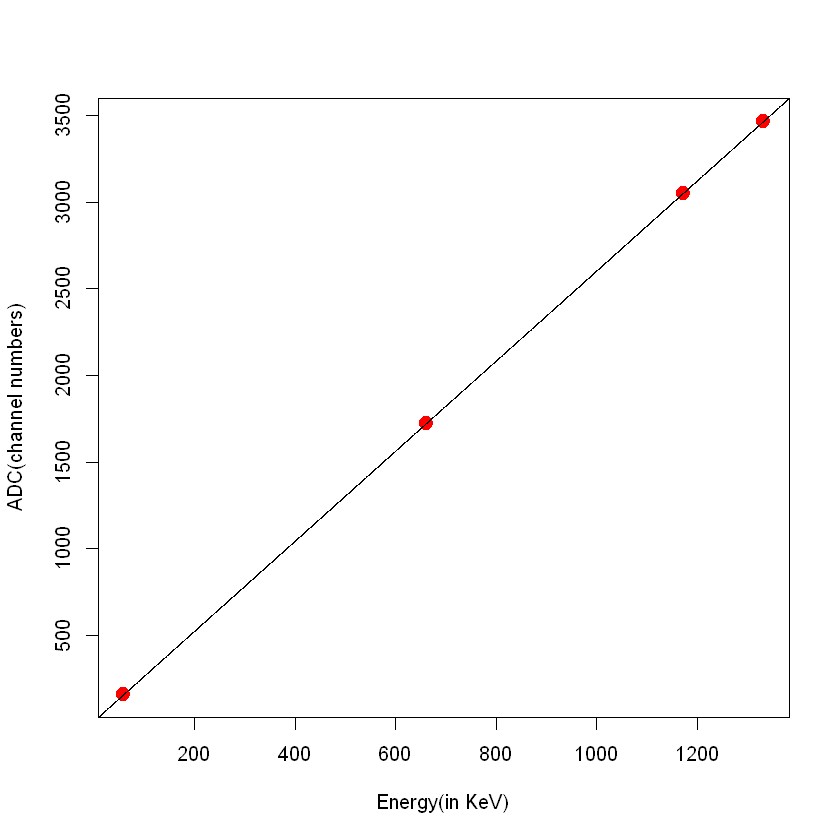

In [65]:
# Plot of ADC(channel numbers) vs Energy(keV) showing that they are perfectly calibrated.
options(repr.plot.width=7, repr.plot.height=7)
plot(df$Energy, df$x0, col="red", pch=19, cex=1.5, xlab="Energy(in KeV)", ylab="ADC(channel numbers)" )
lines(energy,data$x)


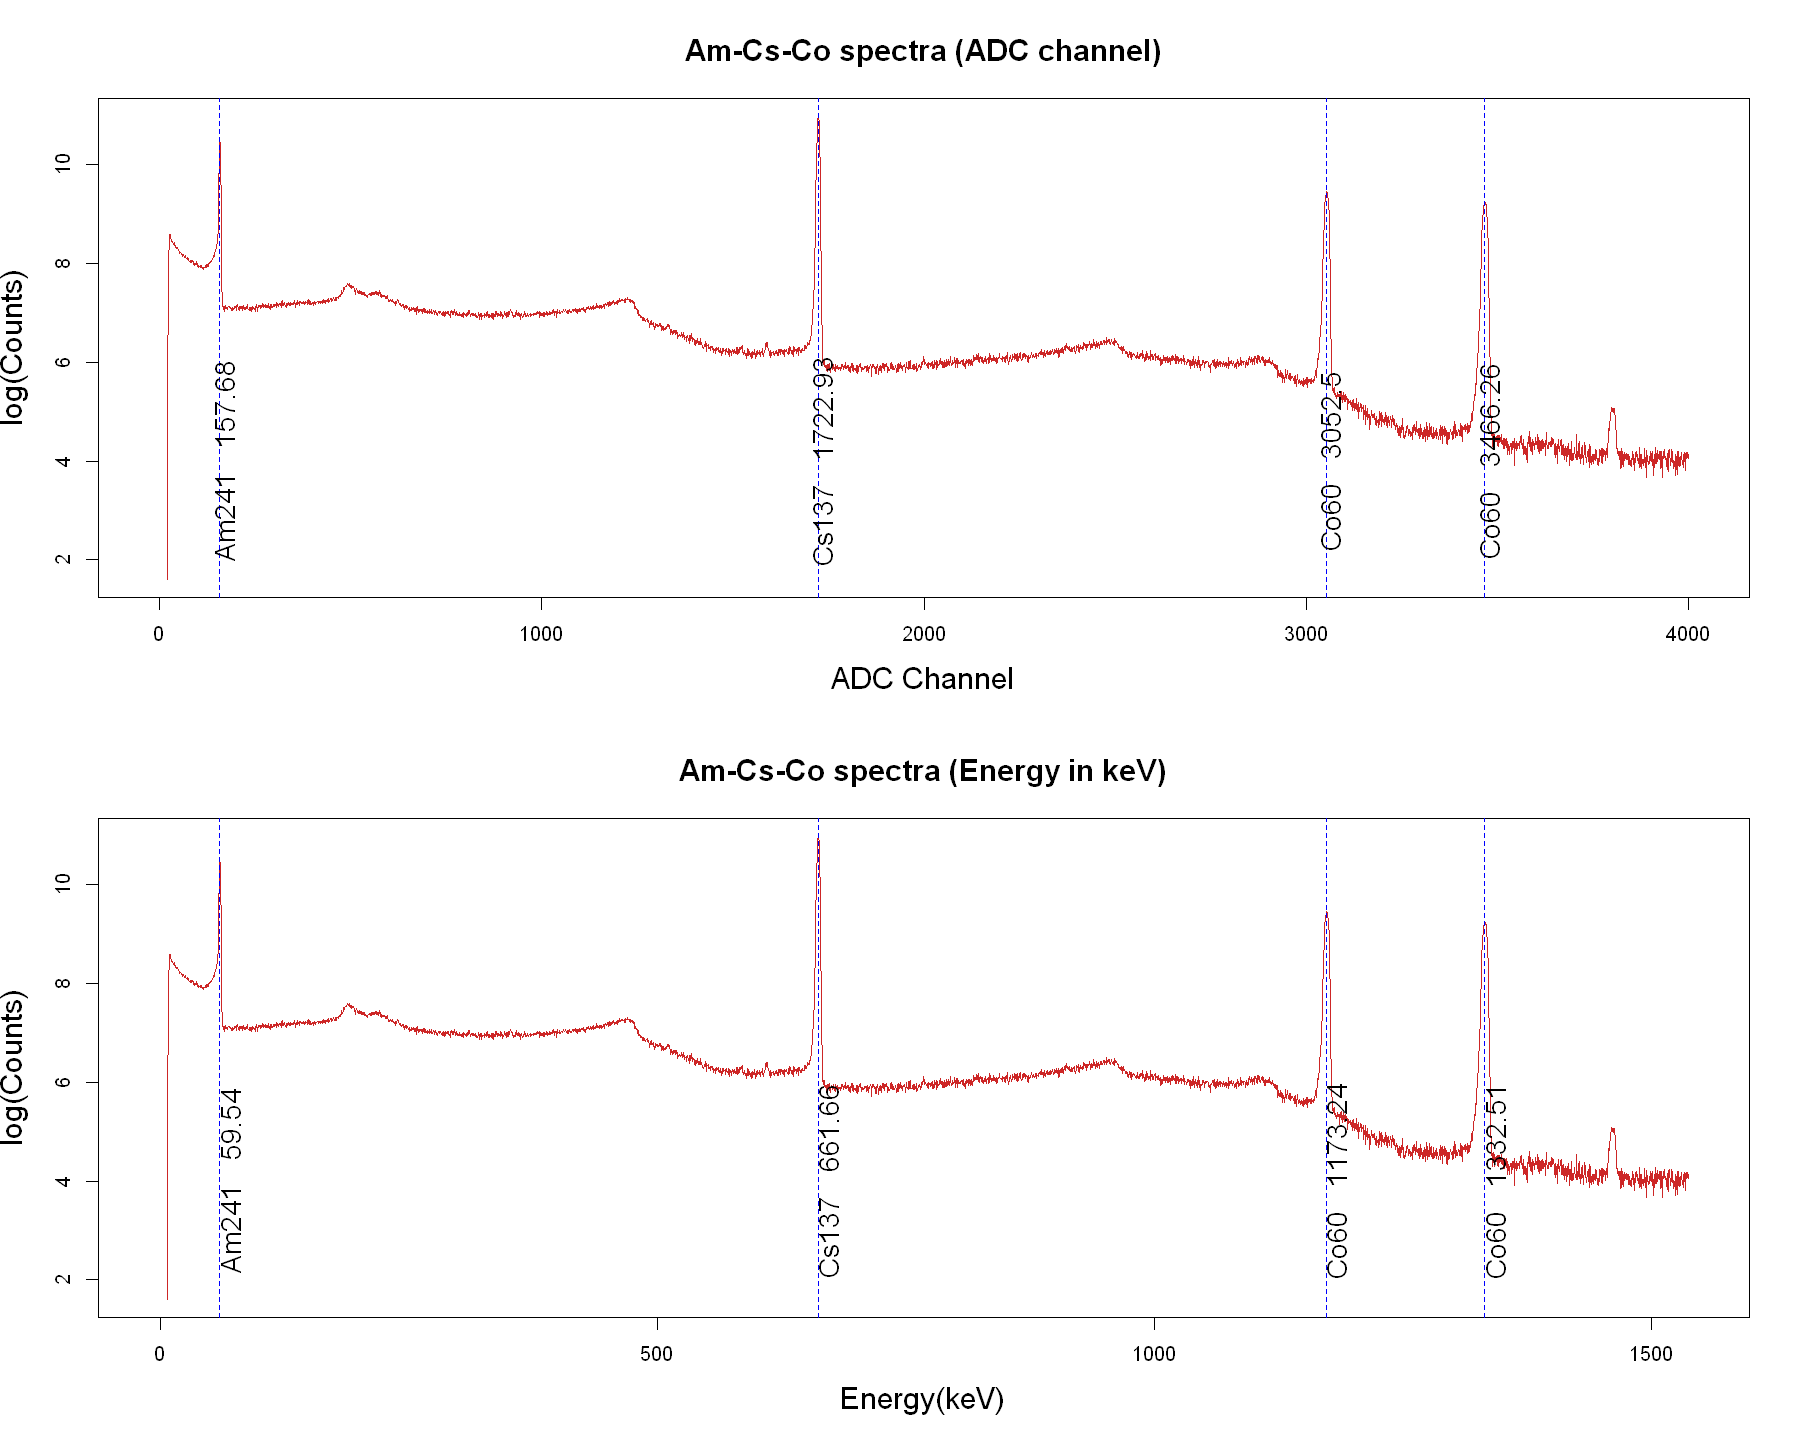

In [67]:
# just checking if indeeed is correct
# log plots comparison, the one with x axis as ADC channel numbers and the other with x axis as Energy(keV)
options(repr.plot.width=15, repr.plot.height=12)
par(mfrow=c(2,1))

emission.lines <- function(vec){
    nuclides <- c("Am241","Cs137","Co60","Co60")
    i=0
    for (line in vec){
        i=i+1
        abline(v=line, col="blue", lty=2, lwd=1)
        text(line+10,4,paste(nuclides[i]," ",round(line,2)),srt=90,cex=1.4)
        
        
    }
}


plot(data$x[1:4000], log(data$y)[1:4000],col='firebrick3',type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="Am-Cs-Co spectra (ADC channel)",cex.main=1.5,cex.lab=1.5)
emission.lines(df$x0)


plot(energy[1:4000], log(data$y)[1:4000],col='firebrick3',type='l',xlab="Energy(keV)",ylab="log(Counts)",
     main="Am-Cs-Co spectra (Energy in keV)",cex.main=1.5,cex.lab=1.5)
emission.lines(df$Energy)


# Estimating the number of events 

## AM-241

In [68]:
#these are the param that we've found for the first peak
params.found <- function(nuclide.estimates){
    for (i in 1:4){
    params <- c("A","B","w","x0")
    cat(params[i],"->",nuclide.estimates[[i]],"\n")
      }
    }

params.found(Am.estimates)


A -> 35095.96 
B -> 2352.588 
w -> 1.961669 
x0 -> 157.6811 


In [69]:
N.events <- function(nuclide.name,nuclide.data, nuclide.estimates){
    
    #empty vector to capture signal data
    S <- vector(mode="numeric", length=length(nuclide.data$x))
    #if we plot the gaussian noise without the constant background we obtained this graph:
    A <- nuclide.estimates$A
    w <- nuclide.estimates$w
    x0 <- nuclide.estimates$x0
    
    for (i in 1:length(nuclide.data$x)){
    S[i]<- (A*exp((-(nuclide.data$x[i]-x0)^2)/(2*w^2)))}
    
    # plot the signal where the params were estimated using JAGS
    options(repr.plot.width=5, repr.plot.height=5)
    plot(nuclide.data$x, S, col='firebrick3', type='l',xlab="ADC Channel",ylab="Only Signal Counts",
     main=paste(nuclide.name," spectra"))

    Signal <- function(x) { (A*exp((-(x-x0)^2)/(2*w^2)))}
    # just integrate in the range of nuclide.data$x , so that the integral value will be zero in those places 
    # where the gaussian function doesn't have any values.
    val <- integrate(Signal,lower = min(nuclide.data$x), upper = max(nuclide.data$x))$value
    cat("Number of events under the",nuclide.name,"peak:",val)
}


Number of events under the Am241 peak: 172573

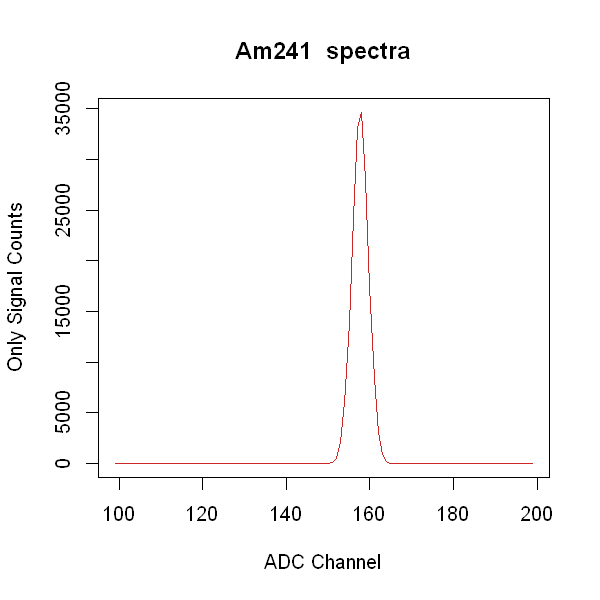

In [70]:
N.events("Am241",Am.data,Am.estimates)

Number of events under the Cs137 peak: 503817.2

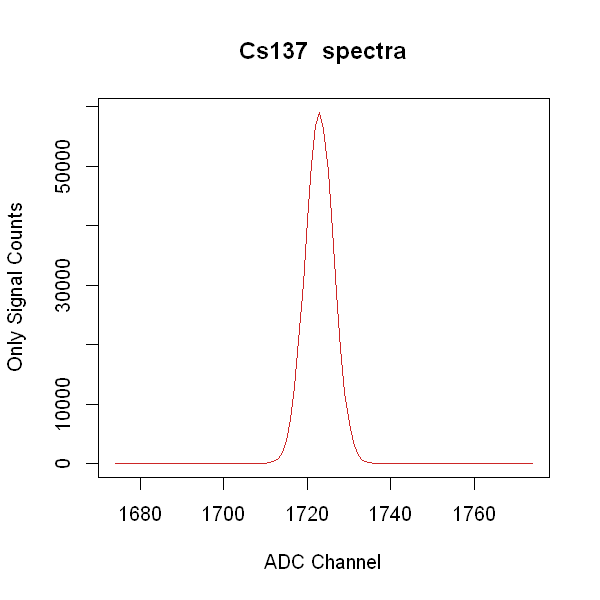

In [71]:
N.events("Cs137",Cs.data,Cs.estimates)

Number of events under the Co(1st peak) peak: 175974.7

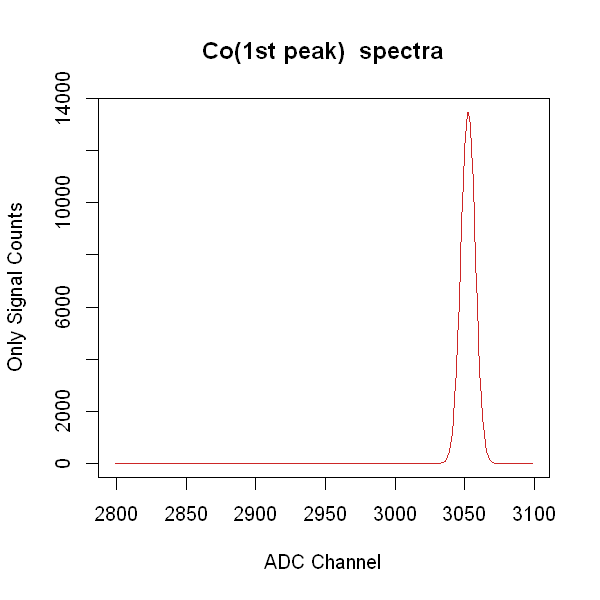

In [72]:
N.events("Co(1st peak)",C01.data,Co1.estimates)

Number of events under the Co(2nd peak) peak: 162298.2

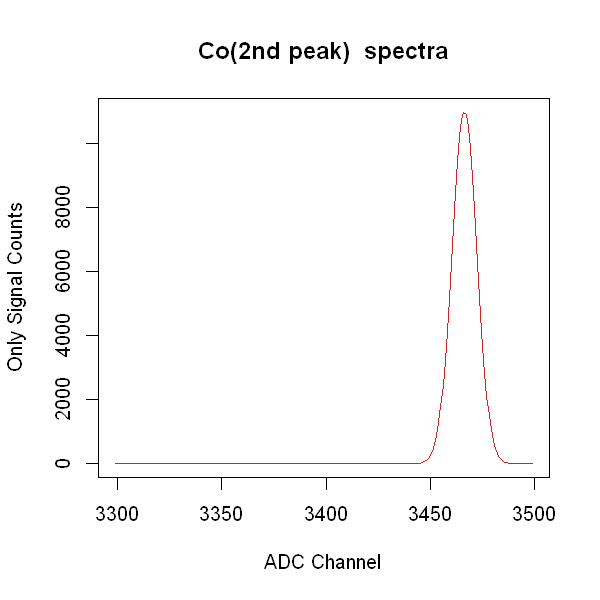

In [73]:
N.events("Co(2nd peak)",C02.data,Co2.estimates)

In [74]:
save(list = ls(all=TRUE), file = "my-session")